<a href="https://colab.research.google.com/github/marinavillatoro/Reconocimiento-Emociones/blob/main/LecturaAudiosFINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC #SVC es como se llama a svm en la libreria
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve

import seaborn as sns
from collections import Counter


In [ ]:
import sys
sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [ ]:
# Conectamos el cuaderno actual con nuestro Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Path
Original = '/content/drive/MyDrive/TFG/Original/'

# Cargar audios


In [ ]:
OriginalAudios = os.listdir(Original)

file_emotion = [] #Almacena emocion
file_path = []    #Almacena ruta del archivo de audio

for file in OriginalAudios:
    file_path.append(Original + file)  #Para cada file, crea ruta con rutaCarpeta+NombreArchivoAudio

    part=file.split('_')  #Divide nombre archivo --> ['UO1', 'F', 'A01','E','01.wav'] --> Tercera parte indica emoción
    if part[2][0] == 'A':
      file_emotion.append('asco')
    elif part[2][0] == 'I':
      file_emotion.append('ira')
    elif part[2][0] == 'M':
      file_emotion.append('miedo')
    elif part[2][0] == 'F':
      file_emotion.append('felicidad')
    elif part[2][0] == 'T':
      file_emotion.append('tristeza')
    elif part[2][0] == 'S':
      file_emotion.append('sorpresa')
    else:
      file_emotion.append('Unknown')

# dataframe para emociones --> 1 coluna llamada Emotions con las emociones
emotion = pd.DataFrame(file_emotion, columns=['Emotions'])


# dataframepara path
path = pd.DataFrame(file_path, columns=['Path'])
Audios_df = pd.concat([emotion, path], axis=1)
Audios_df

Emotions                                               Path
0     tristeza  /content/drive/MyDrive/TFG/Original/U06_M_T07_...
1     tristeza  /content/drive/MyDrive/TFG/Original/U06_M_T02_...
2     tristeza  /content/drive/MyDrive/TFG/Original/U05_M_T05_...
3     tristeza  /content/drive/MyDrive/TFG/Original/U05_M_T04_...
4     tristeza  /content/drive/MyDrive/TFG/Original/U06_M_T04_...
...        ...                                                ...
1340  tristeza  /content/drive/MyDrive/TFG/Original/U06_M_T03_...
1341  tristeza  /content/drive/MyDrive/TFG/Original/U05_M_T04_...
1342  tristeza  /content/drive/MyDrive/TFG/Original/U06_M_T03_...
1343  tristeza  /content/drive/MyDrive/TFG/Original/U06_M_T04_...
1344  tristeza  /content/drive/MyDrive/TFG/Original/U06_M_T03_...

[1345 rows x 2 columns]

In [ ]:
# señales = []
# for path, emotions in zip(Audios_df.Path, Audios_df.Emotions):


#     data, fs = librosa.load(path, sr=None)
#     señales.append(data)

In [ ]:
# def pintar_señal(audio, sr):
#   #y --> serie de tiempo de audio
#   #sr --> velocidad muestreo (predeterminado sr=22050). Para que frm sea la original (y no sr) sr=None cuando cargue sñ
#   librosa.display.waveshow(audio, sr=sr, x_axis='time')
#   plt.title("Señal audio")

In [ ]:
# señal1= señales[3]
# pintar_señal(señal1,16000)

In [ ]:
# señal1_trabajada = señales[3]
# DC = señal1_trabajada.mean()
# MAX = (np.abs(señal1_trabajada)).max()
# señal1_trabajada = (señal1_trabajada - DC) / (MAX - DC)

# pintar_señal(señal1_trabajada,16000)

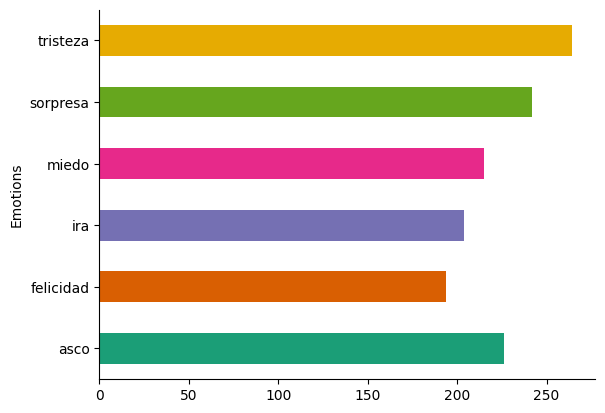

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
Audios_df.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Extracción carasterísticas

In [ ]:
def WinStep(fs,data):
  stWin_seg = 0.02
  st_mframe = stWin_seg * fs
  stWin = st_mframe #tamaño ventana en muestras --> tamaño frame
  stStep = st_mframe

  mtWin_seg = 1
  mt_mframe = mtWin_seg * fs
  mtWin = mt_mframe
  mtStep = 8000

  return stWin, stStep, mtWin, mtStep


In [ ]:
def stEnergy(frame):
  if len(frame) == 0:
      # Manejar el caso en que el array está vacío
    return 0.0  # O devolver algún valor predeterminado apropiado
  return np.sum(frame ** 2) / np.float64(len(frame))

In [ ]:
# def Energy(data, fs, stWin):

#   num_frames = len(data)/ stWin
#   # print(f"num frames {num_frames}")

#   # energia = []
#   EnergyFeature = []

#   for i in np.arange(int(num_frames)):
#     inicio_frame = int(i*stWin)
#     # print(f"inicio frames {inicio_frame}")
#     fin_frame = int((i+1)*stWin)
#     # print(f"fin frames {fin_frame}")
#     x = data[inicio_frame:fin_frame]
#     EnergyFeature.append(stEnergy(x))
#     #  aqui stenergy original y lo voy añadiendo a energia total, que liuego = feature[0]

#   resto_muestras = data[(int(num_frames) * int(stWin)):len(data)]
#   # print(f"resto muestras {len(resto_muestras)}")

#   # Si yo no pongo >=0. Cuando no queden ningunas muestras de pico--> EnergyFeature tendra longitud = num_frames = len(data)/ stWin.
#   #  PERO abajo ( en stFeatureExtraction) he dicho que num_frame = int( len(data) / stWin) +1. ESE MAS UNO ME QUEDA DE PICO (ya que es el frame mas
#   #  con las muestras de pico)
#   if len(resto_muestras)>=0:
#     num_ceros = int(stWin) - len(resto_muestras)
#     frame_113 = np.concatenate((resto_muestras, np.zeros(num_ceros).astype(int)), axis=None)
#     # print(frame_113)
#     x = data[(int(num_frames) * int(stWin)):len(data)]
#     EnergyFeature.append(stEnergy(x))



#   return EnergyFeature

In [ ]:
def Energy(data, fs, stWin):

  num_frames = len(data)/ stWin
  # print(f"num frames {num_frames}")

  # energia = []
  EnergyFeature = []

  # Definir la ventana Hamming
  hamming_window = np.hamming(int(stWin))
  # hanning_window = np.hanning(int(stWin))

  for i in np.arange(int(num_frames)):
    inicio_frame = int(i*stWin)
    fin_frame = int((i+1)*stWin)

    # Aplicar la ventana Hamming al marco
    x = data[inicio_frame:fin_frame] * hamming_window


    EnergyFeature.append(stEnergy(x))
    #  aqui stenergy original y lo voy añadiendo a energia total, que liuego = feature[0]

  resto_muestras = data[(int(num_frames) * int(stWin)):len(data)]
  # print(f"resto muestras {len(resto_muestras)}")

  # Si yo no pongo >=0. Cuando no queden ningunas muestras de pico--> EnergyFeature tendra longitud = num_frames = len(data)/ stWin.
  #  PERO abajo ( en stFeatureExtraction) he dicho que num_frame = int( len(data) / stWin) +1. ESE MAS UNO ME QUEDA DE PICO (ya que es el frame mas
  #  con las muestras de pico)
  if len(resto_muestras)>=0:
    num_ceros = int(stWin) - len(resto_muestras)
    frame_113 = np.concatenate((resto_muestras, np.zeros(num_ceros).astype(int)), axis=None)
    # print(frame_113)
    x = data[(int(num_frames) * int(stWin)):len(data)]
    EnergyFeature.append(stEnergy(x))



  return EnergyFeature

In [ ]:
def stFeatureExtraction(data, fs, stWin, stStep):

  n_mfcc = 12
  totalNumOfFeatures = 1+1+n_mfcc


  num_frame = int( len(data) / stWin) +1
  features = np.zeros((totalNumOfFeatures, num_frame))
  # features = np.array([])

  # features[0] = librosa.feature.rms(y = data, frame_length = 320, hop_length = 320)
  features[0] = Energy(data, fs, stWin)
  features[1] = librosa.feature.zero_crossing_rate(y = data, frame_length = int(stWin), hop_length = int(stWin))
  # features[2:2+n_mfcc] = librosa.feature.mfcc(y= data,n_mfcc=n_mfcc, sr=fs,n_fft=int(stWin/2), hop_length= int(stWin),n_mels=30)
  features[2:2+n_mfcc] = librosa.feature.mfcc(y= data,n_mfcc=n_mfcc, sr=fs,n_fft=512, hop_length= int(stWin),n_mels=30, window='hamm')

  # curFV en original, me da las caracteristicas trama a trama --> (14,1)
  #  aqui tenemos cracteristicas en total ( features)--> (14,114)



  return features



In [ ]:
def  mtFeatureExtraction(data, fs, stWin, stStep, mtWin, mtStep):
  # Calculo promedio y desviacion estandar

  mtWinRatio = int(round(mtWin / stStep)) #Cuantas unidades de ventana corta equivalen a una ventana larga --> 16000/320 = 50
  mtStepRatio = int(round(mtStep / stStep)) #Cuantos unidades de pasos corta equivalen a un paso largo--> 8000/320 = 25


  stFeatures = stFeatureExtraction(data, fs, stWin, stStep) #Estrae caract short-term
  numOfFeatures = len(stFeatures) #14 (2+12)
  numOfStatistics = 2 #Num de datos que va a extraer --> media y desviacion tipica


  mtFeatures = [] #ES UNA LISTA de longitud 28 (2*14) --> para cada caract(14), calcula media y desv (2)

  for i in range(numOfStatistics * numOfFeatures):
      mtFeatures.append([]) #Agrega tanto huecos lista como  2*14


  for i in range(numOfFeatures):
      curPos = 0
      N = len(stFeatures[i]) #numero de frames --> YA NO NUMERO DE FRAMES --> NUM DE VALORES
      #Para stFeatures[i] (==Energia), tenemos 114 valores de energia ( 1 valor por frame)

      while (curPos < N):
          N1 = curPos #desde x
          N2 = curPos + mtWinRatio #hasta x+(num ventanas cortas equivalentes a ventana grande)
          if N2 > N: #si limite superior es mayor que el num de frames, se coje hasta ultimo frame y listo --> tendra menos tamaño de ventana
              N2 = N
          curStFeatures = stFeatures[i][N1:N2]
            # [i] --> caracteristica stFeatures[i] == energia
            # [N1:N2] --> cacho que coje de esa caract --> coge valores energia desde N1 hasta N2

          mtFeatures[i].append(np.mean(curStFeatures)) #Extrae la media
          mtFeatures[i+numOfFeatures].append(np.std(curStFeatures)) #Estrae la desviacion tipica

          curPos += mtStepRatio  #Adelanta cursor desplazamiento equivalente en stStep

  return np.array(mtFeatures), stFeatures

In [ ]:
def FeatureExtraction(AudiosDataFrame):

  allFeatures = np.array([])
  alldata = []

  stFea = []


  for path, emotions in zip(AudiosDataFrame.Path, AudiosDataFrame.Emotions):


    data, fs = librosa.load(path, sr=None)
    # PRUEBA
    # DC = data.mean()
    # MAX = (np.abs(data)).max()
    # data = (data - DC) / (MAX - DC)
    # FIN PRUEBA

    alldata.append(data)
    stWin, stStep, mtWin, mtStep = WinStep(fs,data)
      # print(data)

    mtFeatures, stFeatures_post = mtFeatureExtraction(data, fs,stWin, stStep, mtWin, mtStep)
    stFea.append(stFeatures_post)

    LongTermFeatures = np.transpose(mtFeatures)
    LongTermFeatures = LongTermFeatures.mean(axis=0)


    if len(allFeatures) == 0: #SI PRIMER AUDIO --> PUES =                             # append feature vector
      allFeatures = LongTermFeatures

    else: #SI NO PRIMER AUDIO SE CONCATENA
      allFeatures = np.vstack((allFeatures, LongTermFeatures)) #Apila las matrices verticalmente

  return allFeatures



Pintar filtros Mel

In [ ]:
def CalculoFiltrosMel(fs, num_mel):

  #MEL FILTER BANKS

  filter_banks = librosa.filters.mel(sr=fs, n_fft=512, n_mels=num_mel, fmin=0, fmax = fs/2)

          #n_fft=2048 (por que estandar)
          #fmin=0.0
          #fmax = sr / 2.0 --> Por nyquist fs>=2famx --> fmax <= fs/2


  print(filter_banks.shape) #(num bandas mel, framesize/2 + 1 ) --> framesize==n_fftt

#  Para vean los filtros literales
  plt.figure(figsize=(8, 4))
  for i in range(num_mel):
      plt.plot(filter_banks[i])
      # plt.xlim([0,260])

  plt.xlabel('Índice de frecuencia')
  plt.ylabel('Amplitud')
  plt.title('Filtros triangulares de Mel')
  plt.tight_layout()
  plt.show()


  plt.figure()
  librosa.display.specshow(filter_banks, sr=fs, x_axis="linear")
  plt.colorbar(format="%+2.f")
  plt.show()

  #Al dibujarla podemos contar los 10 filter banks
  #Colores claritos significan 1 y los oscuros 0 --> en referencia a grafica donde se ven los filtros triangulares


In [ ]:
# CalculoFiltrosMel(16000,30)

In [ ]:
allFeatures = FeatureExtraction(Audios_df)



---



Vamos a crear histogramas para ver rango de valores que toman las caracteristicas (allFeatures)

In [ ]:
# num_features = len(allFeatures[0]) #devuelve 28 de (8,28) --> si pongo len(allFeatures) devuelve 8

# for i in range(num_features):
#     plt.figure(figsize=(6, 4))  # Tamaño del gráfico
#     plt.hist(allFeatures[:, i], bins=30, edgecolor='black')  # Crear histograma para la característica i
#     # bins --> cantidad de barras (a menos bins mayor ancho barras --> engloban mas los resultados)
#     plt.title(f'Histograma de la Característica {i+1}')  # Título del histograma
#     plt.xlabel('Valor')  # Etiqueta del eje x
#     plt.ylabel('Frecuencia')  # Etiqueta del eje y
#     plt.grid(True)  # Habilitar cuadrícula
#     plt.show()  # Mostrar el histograma



---


---


Tenemos por un lado las caracteristicas --> allFeatures (8,28) --> Datos entrada

Emotion (8,1) --> Datos salida

# 1. Separar datos

In [ ]:
# #ETIQUETAS NUMERICAS
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(emotion)

# # Obtener la relación entre las emociones originales y los números asignados
# relacion_emociones_numeros = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# # Mostrar la relación
# print(relacion_emociones_numeros)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Hold-out

In [ ]:
# scaler = StandardScaler()
# scaler.fit(allFeatures)
# allFeatures_scaled = scaler.transform(allFeatures)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(allFeatures,emotion, test_size=0.30, shuffle=True, random_state=0)
# x_train_scaled, x_test_scaled_contest, y_train, y_test = train_test_split(allFeatures_scaled,emotion, test_size=0.30, shuffle=True, random_state=0)

    # Arrays --> le paso una unica matriz o array  solo cuando los datos no estan etiquetados
            # Cuando le paso dos, una son los datos y otra las emociones. Divide en test y traen datos y etiquetas, se encarga de la correspondencia
            #  entre datos y etiquetas
    # 70% entrenamiento, 30% test
    # shuffle --> aleatoriedad--> Si =true, datos se mezclaran antes de dividirlos
    # random_state --> representa division de datos. Para que todo el mundo (gente con este codigo) obtenga mismo resultado, hay que asignarle un valor.
            # Controla aleatoreidad de la division de los datos  y q el codigo sea divisible
            # No influye en el rendimiento del modelo


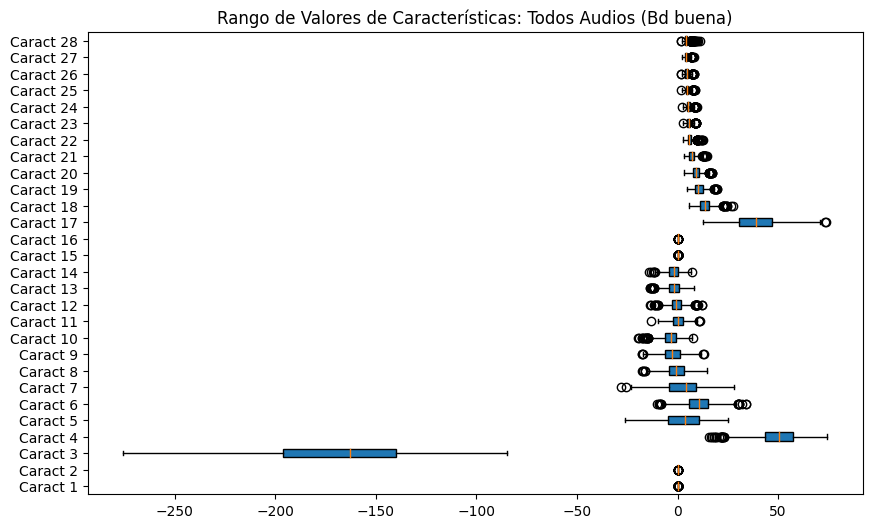

In [ ]:
num_features = len(allFeatures[0])

plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Crear un boxplot para cada característica
plt.boxplot(allFeatures, vert=False, patch_artist=True)

# Configurar etiquetas y título
plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
plt.title('Rango de Valores de Características: Todos Audios (Bd buena)')
# Mostrar la figura
plt.show()

# 2. Preprocesamiento --> normalización


## Hold-out

In [ ]:
# Contruimos estandarizador y lo entrenamos
scaler_train = StandardScaler()
scaler_train.fit(X_train)

StandardScaler()

In [ ]:
# Contruimos estandarizador y lo entrenamos
scaler_test = StandardScaler()
scaler_test.fit(X_test)

StandardScaler()

In [ ]:
x_train_scaled = scaler_train.transform(X_train)
x_test_scaled_contest= scaler_test.transform(X_test)
x_test_scaled = scaler_train.transform(X_test)

normalizaion con minmax

In [ ]:
# mmscaler_train = MinMaxScaler()
# mmscaler_train.fit(X_train)

In [ ]:
# mmscaler_test = MinMaxScaler()
# mmscaler_test.fit(X_test)

In [ ]:
# x_train_scaled = mmscaler_train.transform(X_train)
# x_test_scaled_contest= mmscaler_test.transform(X_test)
# x_test_scaled = mmscaler_train.transform(X_test)

# 3. Entrenamiento --> SVM

## SVM


3.1 Voy a seguir el ejemplo de svm radial de https://cienciadedatos.net/documentos/py24-svm-python

In [ ]:
# scaler_All = StandardScaler()
# scaler_All.fit(allFeatures)
# allfeatures_scaled = scaler_All.transform(allFeatures)


# K-FOLD CROSS

# predicciones = modelo.predict(allfeatures_scaled)
# predic_prob = modelo.predict_proba(allfeatures_scaled)
# accuracy = accuracy_score(emotion,predicciones)
# print(f"Accuracy en el conjunto de datos de entrenamiento: {100*accuracy}%")

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [ ]:
#Busqueda de hiperparametro C  (valor de penalización)

param_grid = {'C': np.logspace(-5, 7, 20)}
  #  Genera 20 valores equispaciados desde 10^-5 hasta 10^7 --> se usan para probar != valores C

grid = GridSearchCV(
        estimator  = SVC(kernel= "rbf", gamma='scale',decision_function_shape='ovr', break_ties=True, probability=True, random_state=0),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = stratified_kfold, #hold-out =10
        verbose    = 0,
        return_train_score = True
      )

  #  GridSearchCV --> busca valores de parametros especificos para un estimador (svm) --> usan validación cruzada
    #  estimator --> modelo a usar
    #  param_grid --> parametros a probar
    #  scoring --> aqui muestra las puntuaciones con distintos valores
    #  n_jobs --> num trabajos ejecutan en paralelo --> -1 =  aprovecha al max capacidad CPU.
    #  cv -->ej: cv=3 --> Dividen datos en 3 partes (folds) y se entrena el modelo 3 veces(en cada vez se usa un conjunto
    #  distinto como prueba). Luego promedian los resultados de todas iteraciones y obtiene media del rendimiento
    #  FOLDS ESENCIALES EN VALIDACIÓN CRUZADA)
    #  verbose --> datos que se van mostrando (=0 --> ninguno)
    #  return_train_score --> dice como va las diferentes configuraciones de parametros.



In [ ]:
y_train_flat = np.ravel(y_train)
# print(y_train_flat.shape)
# print(y_train.shape)
# print(x_train_scaled)
print(y_train.shape)
print(y_train_flat.shape)

(941, 1)
(941,)


In [ ]:
_ = grid.fit(X = x_train_scaled, y = y_train_flat) #HOLD OUT
# _ = grid.fit(X = allfeatures_scaled, y = emotion)
  # ajusta modelo svm usando validación cruzada
  # pone delante _ xq no vamos a usar lo que nos devuelveç

resultados = pd.DataFrame(grid.cv_results_)
  #  crea Dataframe con los resultados con cada hiperparametro C

resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(10)
  # Filtra resultados para mostrar solo los que nos interesan

param_C  mean_test_score  std_test_score  mean_train_score  \
9         4.83293         0.941601        0.028854          0.999882   
10      20.691381         0.941590        0.025140          1.000000   
11      88.586679         0.941590        0.025140          1.000000   
18  2335721.46909         0.941590        0.025140          1.000000   
17  545559.478117         0.941590        0.025140          1.000000   
16   127427.49857         0.941590        0.025140          1.000000   
15   29763.514416         0.941590        0.025140          1.000000   
14    6951.927962         0.941590        0.025140          1.000000   
13    1623.776739         0.941590        0.025140          1.000000   
12     379.269019         0.941590        0.025140          1.000000   

    std_train_score  
9          0.000354  
10         0.000000  
11         0.000000  
18         0.000000  
17         0.000000  
16         0.000000  
15         0.000000  
14         0.000000  
13         0.000000  
12         0.000000

In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 4.832930238571752} : 0.9416013437849943 accuracy


## con predict

In [ ]:
# predicciones = modelo.predict(x_test_scaled_contest)

In [ ]:
# accuracy = accuracy_score(
#             y_true    = y_test,
#             y_pred    = predicciones,
#             normalize = True # =False --> devuelve el numero de las acertadas
#            )
# print("")
# print(f"El accuracy de test es: {100*accuracy}%") #97.029 -->

In [ ]:
# confusion_matrix_res = pd.crosstab(
#     np.ravel(y_test), #np.ravel(emotion)
#     predicciones,
#     rownames=['Real'],
#     colnames=['Predicción']
# )
# confusion_matrix_res

Predicción  asco  felicidad  ira  miedo  sorpresa  tristeza
Real                                                       
asco          73          1    0      1         0         0
felicidad      0         53    0      0         2         0
ira            0          1   53      0         1         0
miedo          1          1    0     60         1         2
sorpresa       0          3    1      0        73         0
tristeza       0          1    0      0         0        76

In [ ]:
# # Obtener las probabilidades de pertenencia a cada clase en el conjunto de prueba
# y_score = modelo.decision_function(x_test_scaled_contest)
# y_prob = modelo.predict_proba(x_test_scaled_contest)

# mapeo_emociones = {0: 'asco', 1: 'felicidad', 2: 'ira', 3: 'miedo', 4: 'sorpresa', 5: 'tristeza'}
# indices_errores = np.where(predicciones != y_test)[0]

# print(indices_errores)
# for indice_error in indices_errores:
#     emocion_prediccion = mapeo_emociones[predicciones[indice_error]]
#     emocion_real = mapeo_emociones[y_test[indice_error]]

#     puntuacion_decision = y_score[indice_error]
#     probabilidades_prediccion = y_prob[indice_error]

#     # probabilidades_prediccion = modelo.predict_proba(X_test)[indice_error]
#     print(f"Índice: {indice_error}, Predicción: {emocion_prediccion}, Real: {emocion_real}, Puntuación de decisión: {probabilidades_prediccion}")

In [ ]:
# plt.figure(figsize=(5,5))
# sns.heatmap(confusion_matrix_res, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
# plt.title('Confusion Matrix', size=20)
# plt.ylabel('Etiqueta real');
# plt.xlabel('Etiqueta prevista');
# all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy)
# plt.show()

In [ ]:
# # Calcular la matriz de confusión
# mc = confusion_matrix(y_test, predicciones)

# # Calcular el porcentaje de acierto para cada etiqueta
# accuracy_per_class = mc.diagonal() / mc.sum(axis=1)

# # Imprimir el porcentaje de acierto para cada etiqueta
# for i, acc in enumerate(accuracy_per_class):
#     print(f'Precisión para la clase {i}: {acc:.2%}')

In [ ]:
# # Informe de clasificación
# informe_clasificacion = classification_report(y_test, predicciones)
# print("Informe de Clasificación:")
# print(informe_clasificacion)z

## Con predict_proba

In [ ]:
mapeo_emociones = {0: 'asco', 1: 'felicidad', 2: 'ira', 3: 'miedo', 4: 'sorpresa', 5: 'tristeza'}
y_test_flat = np.ravel(y_test)

predicciones_prob = modelo.predict_proba(x_test_scaled_contest) #y_prob
prediccion_emocion = []

for i in range(len(x_test_scaled_contest)):
  probabilidades_predichas = predicciones_prob[i]
  emocion_prediccion = np.argmax(probabilidades_predichas)
  prediccion_emocion.append(mapeo_emociones[emocion_prediccion])

  # if y_test_flat[i] != prediccion_emocion[i]:
  #   print("hola")

prediccion_emocion = np.array(prediccion_emocion)


In [ ]:
accuracy_prob = accuracy_score(y_test,prediccion_emocion)
print("")
print(f"El accuracy de test es: {100*accuracy_prob}%") #97.029 -->


El accuracy de test es: 96.03960396039604%


In [ ]:
cm_prob = pd.crosstab(
    np.ravel(y_test), #np.ravel(emotion)
    prediccion_emocion,
    rownames=['Real'],
    colnames=['Predicción']
)
cm_prob

Predicción  asco  felicidad  ira  miedo  sorpresa  tristeza
Real                                                       
asco          73          1    0      1         0         0
felicidad      0         54    0      0         1         0
ira            0          1   53      0         1         0
miedo          1          1    0     60         1         2
sorpresa       0          4    1      0        72         0
tristeza       0          1    0      0         0        76

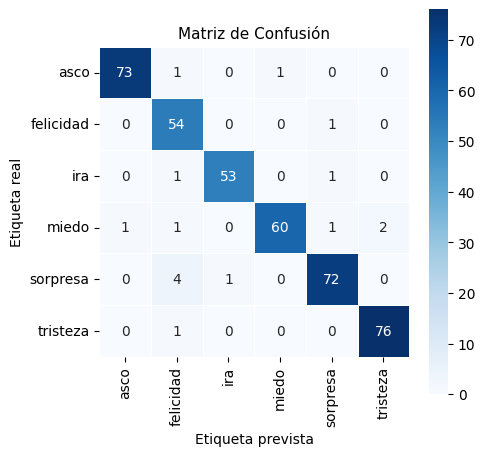

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_prob, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
plt.title('Matriz de Confusión', size=11)
plt.ylabel('Etiqueta real');
plt.xlabel('Etiqueta prevista');
all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy_prob)
plt.show()

In [ ]:
# Calcular la matriz de confusión
mc_p = confusion_matrix(y_test, prediccion_emocion)

# Calcular el porcentaje de acierto para cada etiqueta
accuracy_per_class = mc_p.diagonal() / mc_p.sum(axis=1)

# Imprimir el porcentaje de acierto para cada etiqueta
for i, acc in enumerate(accuracy_per_class):
    print(f'Precisión para la clase {mapeo_emociones[i]}: {acc:.2%}')

Precisión para la clase asco: 97.33%
Precisión para la clase felicidad: 98.18%
Precisión para la clase ira: 96.36%
Precisión para la clase miedo: 92.31%
Precisión para la clase sorpresa: 93.51%
Precisión para la clase tristeza: 98.70%


In [ ]:
# Informe de clasificación
informe_clasificacion = classification_report(y_test, prediccion_emocion)
print("Informe de Clasificación:")
print(informe_clasificacion)

Informe de Clasificación:
              precision    recall  f1-score   support

        asco       0.99      0.97      0.98        75
   felicidad       0.87      0.98      0.92        55
         ira       0.98      0.96      0.97        55
       miedo       0.98      0.92      0.95        65
    sorpresa       0.96      0.94      0.95        77
    tristeza       0.97      0.99      0.98        77

    accuracy                           0.96       404
   macro avg       0.96      0.96      0.96       404
weighted avg       0.96      0.96      0.96       404



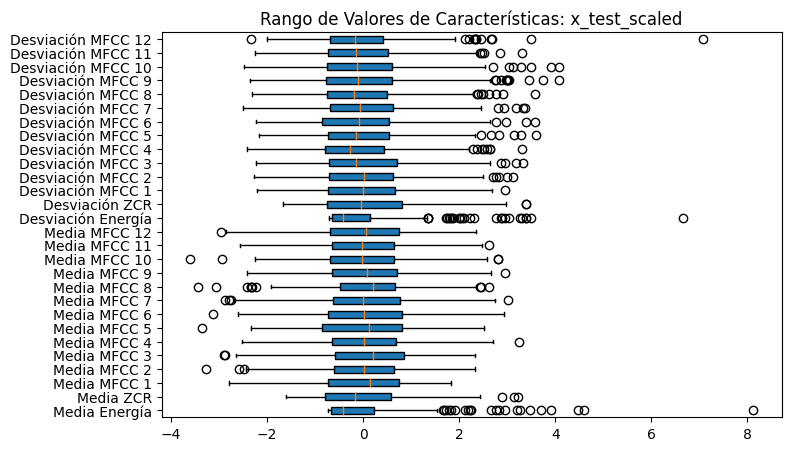

In [ ]:
num_features = len(x_test_scaled[0])
feature_names = ["Media Energía", "Media ZCR", "Media MFCC 1", "Media MFCC 2", "Media MFCC 3", "Media MFCC 4", "Media MFCC 5", "Media MFCC 6","Media MFCC 7",
"Media MFCC 8","Media MFCC 9","Media MFCC 10","Media MFCC 11","Media MFCC 12", "Desviación Energía", "Desviación ZCR", "Desviación MFCC 1", "Desviación MFCC 2", "Desviación MFCC 3",
"Desviación MFCC 4","Desviación MFCC 5","Desviación MFCC 6","Desviación MFCC 7","Desviación MFCC 8","Desviación MFCC 9","Desviación MFCC 10","Desviación MFCC 11","Desviación MFCC 12"]
plt.figure(figsize=(8, 5))  # Tamaño de la figura

# Crear un boxplot para cada característica
plt.boxplot(x_test_scaled, vert=False, patch_artist=True)

# Configurar etiquetas y título
# plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
plt.yticks(range(1, num_features + 1), feature_names)
plt.title('Rango de Valores de Características: x_test_scaled')
# Mostrar la figura
plt.show()

## Codigos para histogramas, unknown...

In [ ]:
# mapeo_emociones = {0: 'asco', 1: 'felicidad', 2: 'ira', 3: 'miedo', 4: 'sorpresa', 5: 'tristeza'}
# y_prob = modelo.predict_proba(x_test_scaled_contest)

mapeo_emociones_numeros = {'asco': 0, 'felicidad': 1, 'ira': 2, 'miedo': 3, 'sorpresa': 4, 'tristeza': 5}

In [ ]:
# mayores = []

# for i in range(len(prediccion_emocion)):
#   probabilidades_predichas = predicciones_prob[i]
#   # Obtenemos los índices ordenados en orden descendente
#   prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]
#   prob_mayor = prob_ordenadas[0]
#   mayores.append(probabilidades_predichas[prob_mayor])


# mayores_ordenadas = np.sort(mayores)

# # Calcular la función de distribución acumulada
# cdf = np.cumsum(mayores_ordenadas)

# # Normalizar la función de distribución acumulada
# cdf = cdf / np.max(cdf)

# # Graficar la función de distribución acumulada
# plt.plot(mayores_ordenadas, cdf)
# plt.xlabel('Probabilidad Máxima')
# plt.ylabel('Probabilidad Acumulada')
# plt.title('Función de Distribución Acumulada de las Probabilidades Máximas')
# # plt.grid(True)
# plt.show()

In [ ]:
print(len(predicciones_prob))

404


In [ ]:
def cdf_Probmax(predicciones_prob, prediccion_emocion, y_test):

  bien_mayores = []
  mal_mayores = []


  indices_errores = np.where(prediccion_emocion != y_test)[0]

  for indice_error in indices_errores:
    probabilidades_predichas = predicciones_prob[indice_error]
    # Obtenemos los índices ordenados en orden descendente
    prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]
    prob_mayor = prob_ordenadas[0]
    mal_mayores.append(probabilidades_predichas[prob_mayor])

  indicesSS_aciertos = np.where(prediccion_emocion == y_test)[0]

  for indice_aciertos in indicesSS_aciertos:
    probabilidades_predichas = predicciones_prob[indice_aciertos]
    # Obtenemos los índices ordenados en orden descendente
    prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]
    prob_mayor = prob_ordenadas[0]
    bien_mayores.append(probabilidades_predichas[prob_mayor])


  # print(bien_mayores)
  # Ordenar las probabilidades máximas de cada grupo de muestras
  prob_bien_ordenadas = np.sort(bien_mayores)
  # print(prob_bien_ordenadas)
  prob_mal_ordenadas = np.sort(mal_mayores)
  # print(prob_mal_ordenadas)

  # # Calcular la función de distribución acumulada para las muestras bien clasificadas
  # cdf_bien = np.cumsum(prob_bien_ordenadas)
  # cdf_bien = cdf_bien / np.max(cdf_bien)

  # # Calcular la función de distribución acumulada para las muestras mal clasificadas
  # cdf_mal = np.cumsum(prob_mal_ordenadas)
  # cdf_mal = cdf_mal / np.max(cdf_mal)

  # # Graficar ambas funciones de distribución acumulada en la misma figura
  # plt.plot(prob_bien_ordenadas, cdf_bien, label='Bien clasificadas')
  # plt.plot(prob_mal_ordenadas, cdf_mal, label='Mal clasificadas')
  # plt.xlabel('Probabilidad Máxima')
  # plt.ylabel('Probabilidad Acumulada')
  # plt.title('Función de Distribución Acumulada de las Probabilidades Máximas')
  # plt.xlim([0,1])
  # plt.legend()
  # plt.grid(True)
  # plt.show()

   # Crear los intervalos del eje x
  intervalos = np.arange(0, 1.1, 0.1)

    # Calcular la función de distribución acumulada para las muestras bien clasificadas
  cdf_bien = [np.sum(prob_bien_ordenadas <= intervalo) / len(prob_bien_ordenadas) for intervalo in intervalos]

    # Calcular la función de distribución acumulada para las muestras mal clasificadas
  cdf_mal = [np.sum(prob_mal_ordenadas <= intervalo) / len(prob_mal_ordenadas) for intervalo in intervalos]

    # Graficar ambas funciones de distribución acumulada en la misma figura
  plt.plot(intervalos, cdf_bien, label='Bien clasificadas')
  plt.plot(intervalos, cdf_mal, label='Mal clasificadas')
  plt.xlabel('Probabilidad Máxima')
  plt.ylabel('Probabilidad Acumulada')
  plt.title('Función de Distribución Acumulada de las Probabilidades Máximas')
  plt.xlim([0,1])
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
def cdf_Probdif(predicciones_prob, prediccion_emocion, y_test_flat):

  bien_dif = []
  mal_dif = []

  indicesSS_aciertos = np.where(prediccion_emocion == y_test_flat)[0]
  for indice_aciertos in indicesSS_aciertos:
    probabilidades_predichas = predicciones_prob[indice_aciertos]
    # Obtenemos los índices ordenados en orden descendente
    prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]
    prob_primera = prob_ordenadas[0]
    prob_segunda = prob_ordenadas[1]
    diferencia = probabilidades_predichas[prob_primera]-probabilidades_predichas[prob_segunda]
    bien_dif.append(diferencia)

  indices_errores = np.where(prediccion_emocion != y_test_flat)[0]
  for indice_error in indices_errores:
    probabilidades_predichas = predicciones_prob[indice_error]
    # Obtenemos los índices ordenados en orden descendente
    prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]
    prob_primera = prob_ordenadas[0]
    prob_segunda = prob_ordenadas[1]
    diferencia = probabilidades_predichas[prob_primera]-probabilidades_predichas[prob_segunda]
    mal_dif.append(diferencia)


  # Ordenar las probabilidades máximas de cada grupo de muestras
  prob_bien_ordenadas = np.sort(bien_dif)
  prob_mal_ordenadas = np.sort(mal_dif)


   # Crear los intervalos del eje x
  intervalos = np.arange(0, 1.1, 0.1)

    # Calcular la función de distribución acumulada para las muestras bien clasificadas
  cdf_bien = [np.sum(prob_bien_ordenadas <= intervalo) / len(prob_bien_ordenadas) for intervalo in intervalos]

    # Calcular la función de distribución acumulada para las muestras mal clasificadas
  cdf_mal = [np.sum(prob_mal_ordenadas <= intervalo) / len(prob_mal_ordenadas) for intervalo in intervalos]

    # Graficar ambas funciones de distribución acumulada en la misma figura
  plt.plot(intervalos, cdf_bien, label='Bien clasificadas')
  plt.plot(intervalos, cdf_mal, label='Mal clasificadas')
  plt.xlabel('Probabilidad Diferencia')
  plt.ylabel('Probabilidad Acumulada')
  plt.title('Función de Distribución Acumulada de las diferencia de probabilidades')
  plt.xlim([0,1])
  plt.legend()
  plt.grid(True)
  plt.show()



In [ ]:
def NuevaClase_Probmax(predicciones_prob,predicciones,X_test,Y_test,Thmax):

  prediccionesNuevas = []
  X_test_nuevo = []
  Y_test_nuevo = []

  perdidas = 0

  for i in range(len(predicciones)):

    probabilidades_predichas = predicciones_prob[i]
    emocion_real = Y_test[i]


    prob_max = np.max(probabilidades_predichas)
    # print(predicciones[i])

    if prob_max>Thmax:
      prediccionesNuevas.append(predicciones[i])
      X_test_nuevo.append(X_test[i])
      Y_test_nuevo.append(Y_test[i])

    else:
      if predicciones[i] == emocion_real:
        perdidas = perdidas +1


  return np.array(prediccionesNuevas), np.array(X_test_nuevo), np.array(Y_test_nuevo), perdidas

In [ ]:
def DescartaFueraUmbral(predicciones_prob,predicciones,X_test,Y_test,Thmax, Thdif):

  prediccionesNuevas = []
  X_test_nuevo = []
  Y_test_nuevo = []
  perdidas = 0
  perdidas_malas = 0
  biendentro =0


  for i in range(len(Y_test)):


    probabilidades_predichas = predicciones_prob[i]
    # Obtenemos los índices ordenados en orden descendente
    prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]

    emocion_real = Y_test[i]
    prob_max = np.max(probabilidades_predichas)
    # print(predicciones[i])


    prob_mayor = prob_ordenadas[0]
    prob_segunda = prob_ordenadas[1]
    diferencia = probabilidades_predichas[prob_mayor] - probabilidades_predichas[prob_segunda]


    if prob_max>Thmax and diferencia>Thdif:
      prediccionesNuevas.append(predicciones[i])
      X_test_nuevo.append(X_test[i])
      Y_test_nuevo.append(Y_test[i])
      if predicciones[i] == emocion_real:
        biendentro = biendentro +1 #Si funciona


    else:
      if predicciones[i] == emocion_real:
        perdidas = perdidas +1
      else:
        perdidas_malas = perdidas_malas+1


  return np.array(prediccionesNuevas), np.array(X_test_nuevo), np.array(Y_test_nuevo), perdidas, perdidas_malas, biendentro

In [ ]:
def ClaseUnknown(predicciones_prob,predicciones,X_test,Y_test, Thmax, Thdif):

  prediccionesNuevas = []
  emocionesNuevas = []
  X_test_nuevo = []
  Y_test_nuevo = []
  perdidas = 0
  perdidas_malas = 0


  for i in range(len(predicciones)):

    probabilidades_predichas = predicciones_prob[i]
    # Obtenemos los índices ordenados en orden descendente
    prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]

    emocion_real = Y_test[i]
    prob_max = np.max(probabilidades_predichas)
    # print(predicciones[i])


    prob_mayor = prob_ordenadas[0]
    prob_segunda = prob_ordenadas[1]
    diferencia = probabilidades_predichas[prob_mayor] - probabilidades_predichas[prob_segunda]


    if prob_max>Thmax and diferencia>Thdif:
      prediccionesNuevas.append(predicciones[i])
      X_test_nuevo.append(X_test[i])
      Y_test_nuevo.append(Y_test[i])

    else:
      prediccionesNuevas.append('unknown')
      X_test_nuevo.append(X_test[i])
      # if(predicciones[i]==)
      Y_test_nuevo.append(Y_test[i])


      if predicciones[i] == emocion_real:
        perdidas = perdidas +1 #--> SI FUERA UMBRAL PERO BIEN PREDICHA --> LA PIERDO
      else:
        perdidas_malas = perdidas_malas +1


  return np.array(prediccionesNuevas), np.array(X_test_nuevo), np.array(Y_test_nuevo), perdidas, perdidas_malas

In [ ]:
def calcular_accuracy_umbral_Prob(predicciones_prob, predicciones_, X_test, Y_test, Thmax_range):
    accuracies_eliminar = []
    accuracies_unknown = []

    for Thmax in Thmax_range:
        prediccionesNuevas, X_test_nuevo, Y_test_nuevo, perdidas, perdidas_malas,biendentro = DescartaFueraUmbral(predicciones_prob, predicciones_, X_test, Y_test, Thmax, 0.0)

        # Calcular accuracy descartando muestras fuera umbral
        # accuracy_eliminar = (len(X_test_nuevo) - perdidas) / len(X_test_nuevo)
        accuracy_eliminar = biendentro/len(X_test_nuevo)
        # biendentro

        # Calcular accuracy considerando muestras "unknown"
        accuracy_unknown = biendentro / len(X_test)




        accuracies_eliminar.append(accuracy_eliminar)
        accuracies_unknown.append(accuracy_unknown)

    # Crear la gráfica con colores específicos
    fig, ax1 = plt.subplots()

    line1, = ax1.plot(Thmax_range, accuracies_eliminar, label='Accuacy dentro umbral', color='red')
    line2, = ax1.plot(Thmax_range, accuracies_unknown, label='Accuracy unknown', color='green')
    ax1.set_xlabel('Umbral de probabilidad máxima (Thmax)')
    ax1.set_ylabel('Accuracy', color='black')
    ax1.tick_params('y', colors='black')
    ax1.set_ylim([0.1, 1])

    # # Crear un segundo eje y para el número de muestras
    # ax2 = ax1.twinx()
    # # ax2.set_ylabel('Numero de muestras', color='black')
    # ax2.set_ylabel('Accuracy', color='green')
    # ax2.tick_params('y', colors='black')
    # # ax2.set_ylim([0.6, 1])

    # Ajustar el diseño para que ambas etiquetas sean visibles
    fig.tight_layout()

    # Agregar la leyenda
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='lower left')

    ax1.grid(True)

    plt.title('Efecto del Umbral Prob max en el Número de Muestras y el Accuracy del Modelo')
    plt.show()


In [ ]:
def calcular_accuracy_umbral_Dif(predicciones_prob, predicciones__, X_test, Y_test, Thdif_range):
    accuracies_eliminar = []
    accuracies_unknown = []

    for Thdif in Thdif_range:
        prediccionesNuevas, X_test_nuevo, Y_test_nuevo, perdidas, perdidas_malas, biendentro = DescartaFueraUmbral(predicciones_prob, predicciones__, X_test, Y_test, 0.0, Thdif)

        # Calcular accuracy sin "eliminar" muestras
        # accuracy_eliminar = (len(X_test_nuevo) - perdidas) / len(X_test_nuevo)
        accuracy_eliminar = biendentro/len(X_test_nuevo)

        # biendentro

        # Calcular accuracy considerando muestras "unknown"
        accuracy_unknown = biendentro / len(X_test)


        accuracies_eliminar.append(accuracy_eliminar)
        accuracies_unknown.append(accuracy_unknown)
      # Crear la gráfica
    fig, ax1 = plt.subplots()

    line1, = ax1.plot(Thmax_range, accuracies_eliminar, label='Accuracy dentro umbral', color='red')
    line2, = ax1.plot(Thmax_range, accuracies_unknown, label='Accuracy unknown', color='green')
    ax1.set_xlabel('Umbral de diferencia de probabilidades (Thdif)')
    ax1.set_ylabel('Accuracy', color='black')
    # ax1.set_ylim([0.6, 1])
    ax1.set_ylim([0.1, 1])
    ax1.tick_params('y', colors='black')

    # # Crear un segundo eje y para el número de muestras
    # ax2 = ax1.twinx()
    # ax2.set_ylabel('Accuracy', color='green')
    # # ax2.set_ylim([0.6, 1])

    # Ajustar el diseño para que ambas etiquetas sean visibles
    fig.tight_layout()

    # Agregar la leyenda
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='lower left')
    ax1.grid(True)

    plt.title('Efecto del Umbral diferencia en el Número de Muestras y el Accuracy del Modelo')
    plt.show()

## tonterias

In [ ]:
# # predicciones
# # y_prob

# for i in range(len(predicciones)):
#   probabilidades_predichas = y_prob[i]
#   emocion_prediccion = np.argmax(probabilidades_predichas)
#   emocion_real =np.ravel(y_test)

#   if predicciones[i] != mapeo_emociones[emocion_prediccion]:
#     print(f"{i} prediccion con predict(): {predicciones[i]}, con max prob con predict_prob(): {mapeo_emociones[emocion_prediccion]}. Real: {emocion_real[i]}")


#     if emocion_real[i] != predicciones[i]:
#       print(f"   Clase Mal predicha {i}: Real: {emocion_real[i]}, predict(): {predicciones[i]} y predict_proba(): {mapeo_emociones[emocion_prediccion]} ")

#     print("\n")



In [ ]:
# def HistogramaPredichaMenosReal(predicciones, X_audios, Y_emociones):

#   diferencias = []

#   indices_errores = np.where(predicciones != Y_emociones)[0]
#   y_prob = modelo.predict_proba(X_audios)  #Calcula todas las predicciones

#   for indice_error in indices_errores:

#     emocion_real = Y_emociones[indice_error]
#     probabilidades_predichas = y_prob[indice_error]
#     emocion_prediccion = np.argmax(probabilidades_predichas) #Emocion predicha, aquella con mayor probabilidad


#     # if predicciones[indice_error] != emocion_prediccion:
#       # Si la prediccion no coincide con el max --> usamos predict() para calcular prediccion ( ya que esto es lo que va a aparecer en matrix)
#     diferencia = y_prob[indice_error,predicciones[indice_error]] - probabilidades_predichas[emocion_real]
#       # print(f" distintas {indice_error}, {diferencia}")
#     # else:
#     #   diferencia = probabilidades_predichas[emocion_prediccion] - probabilidades_predichas[emocion_real]

#     diferencias.append(diferencia)

#     # Valores numericos
#     #print(f"Índice: {indice_error}, diferencias: {diferencia}, Predicción: {mapeo_emociones[emocion_prediccion]}, Real: {mapeo_emociones[emocion_real]}, Puntuación de decisión: {probabilidades_predichas}")
#     print(f"Índice: {indice_error}, diferencias: {diferencia}, Predicción: {mapeo_emociones[predicciones[indice_error]]}, Real: {mapeo_emociones[emocion_real]}, Puntuación de decisión: {probabilidades_predichas}")
#   # Crear el histograma
#   bins = np.arange(0, 1, 0.1)  # Define los intervalos de las barras
#   plt.hist(diferencias, bins=bins, edgecolor='black')
#   plt.xlabel('Diferencia de Probabilidad')
#   plt.ylabel('Frecuencia')
#   plt.title('Histograma de diferencias entre probabilidades de emociones predichas y reales')
#   plt.show()

In [ ]:
# def HistogramaPredichaMenosReal_max(predicciones, X_audios, Y_emociones):

#   diferencias = []
#   y_prob = modelo.predict_proba(X_audios)  #Calcula todas las predicciones
#   malas = []


#   for i in range(len(predicciones)): #Recorre todas las predicciones

#     probabilidades_predichas_indice = y_prob[i] #Obtiene las probabilidades para cada audio
#     emocion_prediccion_indice = np.argmax(probabilidades_predichas_indice)
#     if emocion_prediccion_indice != Y_emociones[i]: #Si la emocion max no coincide con al real --> pues la cuenta --> para ver numero de mal
#       malas.append(i)


#   for indice_error in malas: #Recorre las malas

#     emocion_real = Y_emociones[indice_error]
#     probabilidades_predichas = y_prob[indice_error]
#     emocion_prediccion = np.argmax(probabilidades_predichas) #Emocion predicha, aquella con mayor probabilidad

#     diferencia = probabilidades_predichas[emocion_prediccion] - probabilidades_predichas[emocion_real]
#     diferencias.append(diferencia)

#     # Valores numericos
#     print(f"Índice: {indice_error}, diferencias: {diferencia}, Predicción: {mapeo_emociones[emocion_prediccion]}, Real: {mapeo_emociones[emocion_real]}, Puntuación de decisión: {probabilidades_predichas}")
#     # print(f"Índice: {indice_error}, diferencias: {diferencia}, Predicción: {mapeo_emociones[predicciones[malas]]}, Real: {mapeo_emociones[emocion_real]}, Puntuación de decisión: {probabilidades_predichas}")
#   # Crear el histograma
#   bins = np.arange(0, 1, 0.1)  # Define los intervalos de las barras
#   plt.hist(diferencias, bins=bins, edgecolor='black')
#   plt.xlabel('Diferencia de Probabilidad')
#   plt.ylabel('Frecuencia')
#   plt.title('Histograma de diferencias entre probabilidades de emociones predichas (con max prob) y reales')
#   plt.show()

In [ ]:
# def HistogramaPredichaMenosReal_conmax_indicemc(predicciones, X_audios, Y_emociones):

#   diferencias = []

#   indices_errores = np.where(predicciones != Y_emociones)[0]
#   y_prob = modelo.predict_proba(X_audios)  #Calcula todas las predicciones

#   for indice_error in indices_errores:

#     emocion_real = Y_emociones[indice_error]
#     probabilidades_predichas = y_prob[indice_error]
#     emocion_prediccion = np.argmax(probabilidades_predichas) #Emocion predicha, aquella con mayor probabilidad

#     diferencia = probabilidades_predichas[emocion_prediccion] - probabilidades_predichas[emocion_real]
#     diferencias.append(diferencia)

#     # Valores numericos
#     #print(f"Índice: {indice_error}, diferencias: {diferencia}, Predicción: {mapeo_emociones[emocion_prediccion]}, Real: {mapeo_emociones[emocion_real]}, Puntuación de decisión: {probabilidades_predichas}")
#     # print(f"Índice: {indice_error}, diferencias: {diferencia}, Predicción: {mapeo_emociones[predicciones[indice_error]]}, Real: {mapeo_emociones[emocion_real]}, Puntuación de decisión: {probabilidades_predichas}")
#   # Crear el histograma
#   bins = np.arange(0, 1, 0.1)  # Define los intervalos de las barras
#   plt.hist(diferencias, bins=bins, edgecolor='black')
#   plt.xlabel('Diferencia de Probabilidad')
#   plt.ylabel('Frecuencia')
#   plt.title('Histograma de diferencias entre probabilidades de emociones predichas (max) y reales')
#   plt.show()

## histogramas

In [ ]:
def HistogramaPredichaMenosReal(predicciones_prob, predicciones, X_audios, Y_emociones):

  diferencias = []
  indices_errores = np.where(predicciones != Y_emociones)[0]

  for indice_error in indices_errores:

    emocion_predicha = mapeo_emociones_numeros[predicciones[indice_error]]  #'feliz' --> predicho con prob
    emocion_real = mapeo_emociones_numeros[Y_emociones[indice_error]] #'feliz'

    probabilidades_predichas = predicciones_prob[indice_error]

    diferencia = probabilidades_predichas[emocion_predicha] - probabilidades_predichas[emocion_real]
    diferencias.append(diferencia)

    # Valores numericos
    # print(f"Índice: {indice_error}, diferencias: {diferencia}, Predicción: {predicciones[indice_error]}, Real: {Y_emociones[indice_error]}, Puntuación de decisión: {probabilidades_predichas}")

  # Crear el histograma
  bins = np.arange(0, 1, 0.1)  # Define los intervalos de las barras
  plt.hist(diferencias, bins=bins, edgecolor='black')
  plt.xlabel('Diferencia de Probabilidad')
  plt.ylabel('Frecuencia')
  plt.title('Histograma de diferencias entre probabilidades de emociones predichas (max) y reales')
  plt.show()

In [ ]:
# predicciones_prob --> (404,6) ndarray contiene prob para cada clsae por cada emocion
# prediccion_emocion --> (404,) ndarray contiene cada clase para cada audio (con prob max) --> 'miedo' --> PREDICHA
# x_test_scaled_contest -->(404,28) ndarray features para cada audio de test
# y_test_flat --> (404,) ndarray clase por cada audio de test --> 'miedo' --> REAL


HistogramaPredichaMenosReal(predicciones_prob, prediccion_emocion, x_test_scaled_contest, y_test_flat)

In [ ]:
def HistogramaPrimeraMenosSegunda(predicciones_prob,predicciones, X_test, Y_test):
  diferencias = []
  indices_errores = np.where(predicciones != Y_test)[0]

  for indice_error in indices_errores:

      probabilidades_predichas = predicciones_prob[indice_error]
      # Obtenemos los índices ordenados en orden descendente
      prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]

      # El segundo valor más grande corresponde al índice en la posición 1
      prob_mayor = prob_ordenadas[0]
      prob_segunda = prob_ordenadas[1]

      # Calcular la diferencia entre la probabilidad asignada y real
      diferencia = probabilidades_predichas[prob_mayor] - probabilidades_predichas[prob_segunda]
      diferencias.append(diferencia)

      # Valores numericos
      # print(f"Índice: {indice_error}, diferencia: {diferencia}, Mayor: {mapeo_emociones[prob_mayor]}, Segunda: {mapeo_emociones[prob_segunda]}, Puntuación de decisión: {probabilidades_predichas}")
  # Crear el histograma
  bins = np.arange(0, 1, 0.1)  # Define los intervalos de las barras
  plt.hist(diferencias, bins=bins, edgecolor='black')
  plt.xlabel('Diferencia de Probabilidad')
  plt.ylabel('Frecuencia')
  plt.title('Histograma de diferencias entre probabilidades mayor y segunda')
  plt.show()

In [ ]:
HistogramaPrimeraMenosSegunda(predicciones_prob,prediccion_emocion, x_test_scaled_contest, y_test_flat)

In [ ]:
def HistogramaPrimeraMenosSegundaCORRECTAS(predicciones_prob,predicciones, X_test, Y_test):
  diferencias = []
  indices_correctas = np.where(predicciones == Y_test)[0]

  for i in indices_correctas:

      probabilidades_predichas = predicciones_prob[i]
      # Obtenemos los índices ordenados en orden descendente
      prob_ordenadas = np.argsort(probabilidades_predichas)[::-1]

      # El segundo valor más grande corresponde al índice en la posición 1
      prob_mayor = prob_ordenadas[0]
      prob_segunda = prob_ordenadas[1]

      # Calcular la diferencia entre la probabilidad asignada y real
      diferencia = probabilidades_predichas[prob_mayor] - probabilidades_predichas[prob_segunda]
      diferencias.append(diferencia)

      # Valores numericos
      # print(f"Índice: {indice_error}, diferencia: {diferencia}, Mayor: {mapeo_emociones[prob_mayor]}, Segunda: {mapeo_emociones[prob_segunda]}, Puntuación de decisión: {probabilidades_predichas}")
  # Crear el histograma
  bins = np.arange(0, 1, 0.1)  # Define los intervalos de las barras
  plt.hist(diferencias, bins=bins, edgecolor='black')
  plt.xlabel('Diferencia de Probabilidad')
  plt.ylabel('Frecuencia')
  plt.title('Histograma de diferencias entre probabilidades mayor y segunda (clases correctas)')
  plt.show()

In [ ]:
HistogramaPrimeraMenosSegundaCORRECTAS(predicciones_prob,prediccion_emocion, x_test_scaled_contest, y_test_flat)

In [ ]:
def HistogramaProbmax(predicciones_prob, prediccion_emocion, X_test, Y_test):
  ProbMaxs = []
  indices_errores = np.where(prediccion_emocion != Y_test)[0]
  for indice_error in indices_errores:

      probabilidades_predichas = predicciones_prob[indice_error]
      emocion_predicha = prediccion_emocion[indice_error]
      numero_emocion_predicha = mapeo_emociones_numeros[emocion_predicha]
      prob_max = probabilidades_predichas[numero_emocion_predicha]

      ProbMaxs.append(prob_max)

      # print(f"Índice: {indice_error}, probabilidades: {probabilidades_predichas}, Probabilidad maxima: {probabilidades_predichas[prob_max]}")

  # Crear el histograma
  bins = np.arange(0, 1, 0.1)  # Define los intervalos de las barras
  plt.hist(ProbMaxs, bins=bins, edgecolor='black')
  plt.xlabel('Distribución Probabilidad')
  plt.ylabel('Frecuencia')
  plt.title('Histograma de las probabilidades máximas para clases mal clasificadas')
  plt.show()

In [ ]:
HistogramaProbmax(predicciones_prob,prediccion_emocion, x_test_scaled_contest, y_test_flat)

In [ ]:
def HistogramaProbmax_correctas(predicciones_prob, prediccion_emocion, X_test, Y_test):
  ProbMaxs = []
  indice_aciertos = np.where(prediccion_emocion == Y_test)[0]

  for i in indice_aciertos:

      probabilidades_predichas = predicciones_prob[i]
      emocion_predicha = prediccion_emocion[i]
      numero_emocion_predicha = mapeo_emociones_numeros[emocion_predicha]
      prob_max = probabilidades_predichas[numero_emocion_predicha]

      ProbMaxs.append(prob_max)
      # print(f"Índice: {indice_error}, probabilidades: {probabilidades_predichas}, Probabilidad maxima: {probabilidades_predichas[prob_max]}")

  # Crear el histograma
  bins = np.arange(0, 1, 0.1)  # Define los intervalos de las barras
  plt.hist(ProbMaxs, bins=bins, edgecolor='black')
  plt.xlabel('Distribución Probabilidad')
  plt.ylabel('Frecuencia')
  plt.title('Histograma de las probabilidades máximas para clases bien clasificadas')
  plt.show()

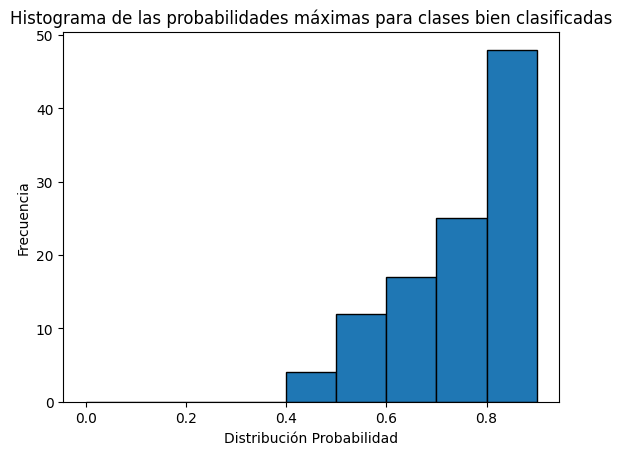

In [ ]:
HistogramaProbmax_correctas(predicciones_prob,prediccion_emocion, x_test_scaled_contest, y_test_flat)

In [ ]:
def HistogramaProbmaxTODAS(prediccion_emocion, X_test, Y_test):

  ProbMax = []
  y_prob = modelo.predict_proba(X_test)  #Calcula todas las probabilidades
  # print(y_prob.shape)
  for i in range(len(X_test)):

      probabilidades_predichas = y_prob[i]
      # print(probabilidades_predichas.shape)
      emocion_predicha = prediccion_emocion[i]
      # print(emocion_predicha.shape)
      numero_emocion_predicha = mapeo_emociones_numeros[emocion_predicha]
      # print(numero_emocion_predicha.shape)
      prob_max = probabilidades_predichas[numero_emocion_predicha]
      # print(prob_max.shape)

      ProbMax.append(prob_max)
      # print(f"Índice: {indice_error}, probabilidades: {probabilidades_predichas}, Probabilidad maxima: {probabilidades_predichas[prob_max]}")

  # Crear el histograma
  bins = np.arange(0, 1, 0.1)  # Define los intervalos de las barras
  plt.hist(ProbMax, bins=bins, edgecolor='black')
  plt.xlabel('Distribución Probabilidad')
  plt.ylabel('Frecuencia')
  plt.title('Histograma de las probabilidades máximas para clases bien clasificadas')
  plt.show()

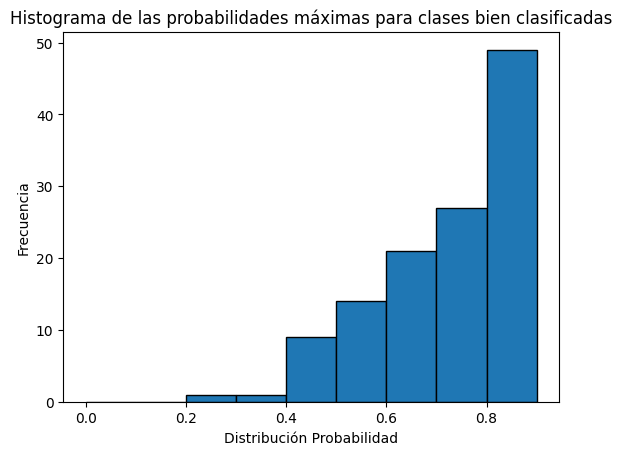

In [ ]:
HistogramaProbmaxTODAS(prediccion_emocion, x_test_scaled_contest, y_test_flat)

## Umbral y unknow

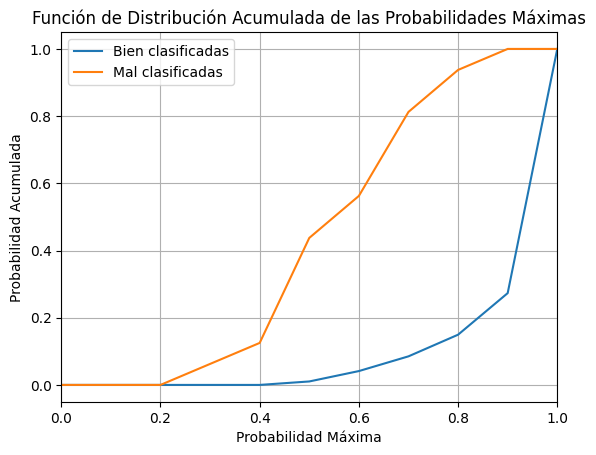

In [ ]:
cdf_Probmax(predicciones_prob, prediccion_emocion, y_test_flat)

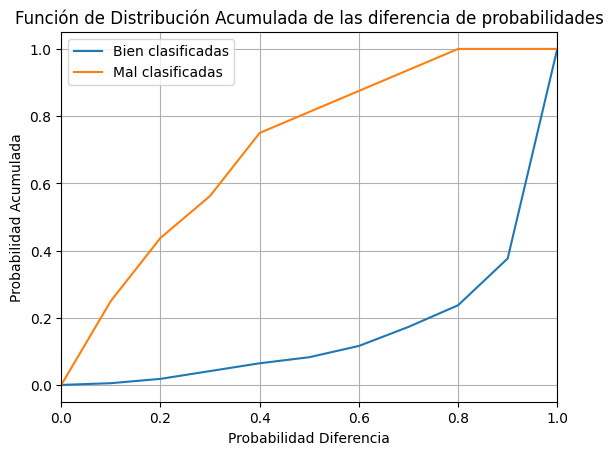

In [ ]:
cdf_Probdif(predicciones_prob, prediccion_emocion, y_test_flat)

In [ ]:
# prediccionesNuevas, X_test_nuevo, Y_test_nuevo, perdidas = NuevaClase_Probmax(predicciones_prob,prediccion_emocion, x_test_scaled, y_test_flat,0.5)

In [ ]:
# accuracy_nuevo = accuracy_score(Y_test_nuevo,prediccionesNuevas)
# print("")
# print(f"El accuracy de test es: {100*accuracy_nuevo}%, pero se tienen {perdidas} perdidas de datos bien clasificados")

In [ ]:
ThMax_ = 0.5
ThDif_ = 0.2
predicciones_ConUn, X_test__ConUn, Y_test_ConUn, perdidas_ConUn, perdidas_malas_ConUn = ClaseUnknown(predicciones_prob,prediccion_emocion, x_test_scaled, y_test_flat, ThMax_, ThDif_)

predicciones_Ignorando, X_test_Ignorando, Y_test_Ignorando, perdidas_Ignorando, perdidas_malas_Ignorando, biendentro = DescartaFueraUmbral(predicciones_prob,prediccion_emocion, x_test_scaled, y_test_flat, ThMax_, ThDif_)


In [ ]:
accuracy_ConUn = accuracy_score(Y_test_ConUn,predicciones_ConUn)
print("")
print(f"El accuracy (creando Unknown) para ThprobMax={ThMax_} y Thdif={ThDif_} es: {100*accuracy_ConUn}%, \npero se tienen {perdidas_ConUn} perdidas de datos bien clasificados y {perdidas_malas_ConUn} perdidas de datos mal clasificados")

print("")
accuracy_Ignorando = accuracy_score(Y_test_Ignorando,predicciones_Ignorando)
print(f"El accuracy (ignorando muestras fuera umbral) para ThprobMax={ThMax_} y Thdif={ThDif_} es: {100*accuracy_Ignorando}%, \npero se tienen {perdidas_Ignorando} perdidas de datos bien clasificados y {perdidas_malas_Ignorando} perdidas de datos mal clasificados")



El accuracy (creando Unknown) para ThprobMax=0.5 y Thdif=0.2 es: 93.8118811881188%, 
pero se tienen 9 perdidas de datos bien clasificados y 8 perdidas de datos mal clasificados

El accuracy (ignorando muestras fuera umbral) para ThprobMax=0.5 y Thdif=0.2 es: 97.9328165374677%, 
pero se tienen 9 perdidas de datos bien clasificados y 8 perdidas de datos mal clasificados


In [ ]:
cm_unknown = pd.crosstab(
    Y_test_ConUn, #np.ravel(emotion)
    predicciones_ConUn,
    rownames=['Real'],
    colnames=['Predicción']
)
cm_unknown

Predicción  asco  felicidad  ira  miedo  sorpresa  tristeza  unknown
Real                                                                
asco          72          1    0      0         0         0        2
felicidad      0         51    0      0         1         0        3
ira            0          0   53      0         0         0        2
miedo          0          0    0     58         1         2        4
sorpresa       0          2    1      0        69         0        5
tristeza       0          0    0      0         0        76        1

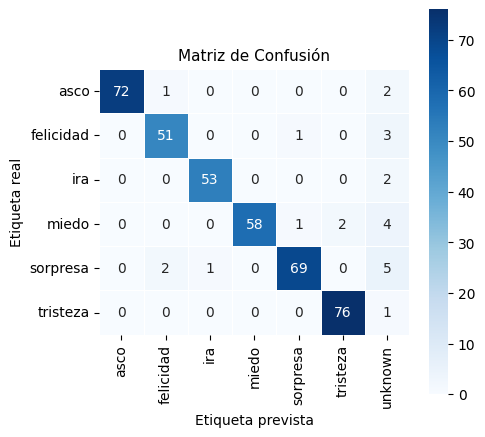

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_unknown, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
plt.title('Matriz de Confusión', size=11)
plt.ylabel('Etiqueta real');
plt.xlabel('Etiqueta prevista');
all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy_ConUn)
plt.show()

In [ ]:
# prediccionesNuevasT, X_test_nuevoT, Y_test_nuevoT, perdidasT, biendentroT = DescartaFueraUmbral(predicciones_prob,prediccion_emocion, x_test_scaled, y_test_flat, 0.5, 0.0)


In [ ]:
# accuracy_nuevoT = accuracy_score(Y_test_nuevoT,prediccionesNuevasT)
# print("")
# print(f"El accuracy de test es: {100*accuracy_nuevoT}%, pero se tienen {perdidasT} perdidas de datos bien clasificados")

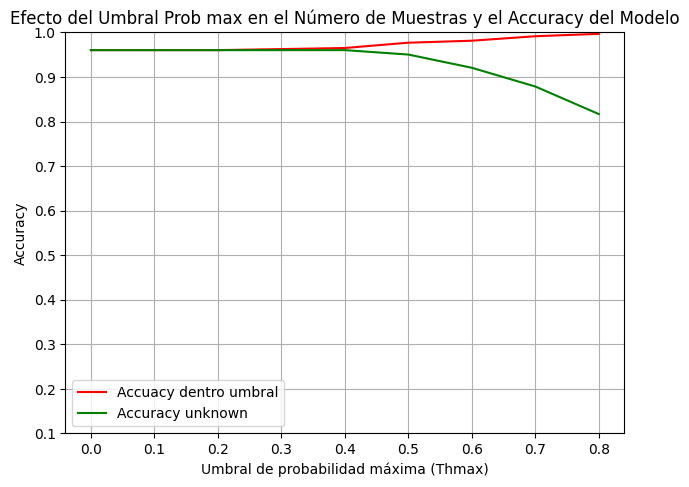

In [ ]:
# Rango de valores para Thmax
Thmax_range = np.arange(0.0, 0.9, 0.1)

calcular_accuracy_umbral_Prob(predicciones_prob, prediccion_emocion, x_test_scaled, y_test_flat, Thmax_range)

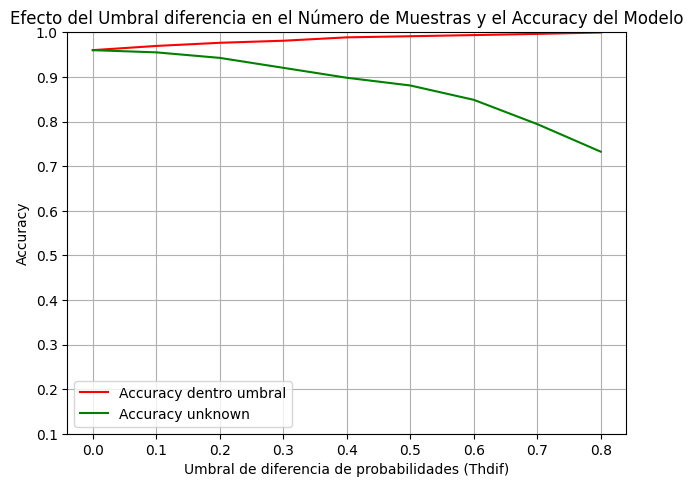

In [ ]:
# Rango de valores para Thmax
Thdif_range = np.arange(0.0, 0.9, 0.1)

# Obtener accuracies
calcular_accuracy_umbral_Dif(predicciones_prob, prediccion_emocion, x_test_scaled, y_test_flat, Thdif_range)


## roc y pruebas

In [ ]:
# # ROC
# # ==============================================================================

# # Obtener las probabilidades de pertenencia a cada clase en el conjunto de prueba
# y_score = modelo.decision_function(x_test_scaled)
# # y_prob = modelo.predict_proba(x_test_scaled)

# # Binarizar las etiquetas de prueba --> 1 la clase a la que pertenece
# y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))


# # Calcular y graficar las curvas ROC para cada clase
# plt.figure(figsize=(8, 6))
# for i in range(len(np.unique(y_encoded))):
#     fpr, tpr, thresholds_roc = roc_curve(y_test_bin[:, i], y_score[:, i])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatorio')
# plt.xlabel('Tasa de Falsos Positivos (FPR)')
# plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
# plt.title('Curvas ROC para cada clase')
# plt.legend()
# plt.show()

In [ ]:
# # ROC
# # ==============================================================================

# # Obtener las probabilidades de pertenencia a cada clase en el conjunto de prueba
# y_score = modelo.decision_function(x_test_scaled)
# # y_prob = modelo.predict_proba(x_test_scaled)

# # Binarizar las etiquetas de prueba --> 1 la clase a la que pertenece
# y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))

# # Inicializar variables para almacenar el umbral óptimo y los valores asociados
# umbral_optimo = None
# fpr_optimo = None
# tpr_optimo = None
# distancia_optima = float('inf')  # Inicializar con un valor grande

# # Calcular y graficar las curvas ROC para cada clase
# plt.figure(figsize=(8, 6))
# for i in range(len(np.unique(y_encoded))):
#     fpr, tpr, thresholds_roc = roc_curve(y_test_bin[:, i], y_score[:, i])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')

#     # Encontrar el umbral óptimo más cercano al vértice superior izquierdo
#     for j in range(len(fpr)):
#         distancia_actual = np.sqrt((fpr[j] - 0)**2 + (tpr[j] - 1)**2)
#         if distancia_actual < distancia_optima:
#             distancia_optima = distancia_actual
#             umbral_optimo = thresholds_roc[j]
#             print(umbral_optimo)
#             fpr_optimo = fpr[j]
#             tpr_optimo = tpr[j]

# # Imprimir el umbral óptimo y sus valores asociados
# print(f"Umbral Óptimo: {umbral_optimo}")
# print(f"FPR Óptimo: {fpr_optimo}")
# print(f"TPR Óptimo: {tpr_optimo}")

# plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatorio')
# plt.xlabel('Tasa de Falsos Positivos (FPR)')
# plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
# plt.title('Curvas ROC para cada clase')
# plt.legend()
# plt.show()

In [ ]:
# # Establecer el umbral deseado
# umbral = 5
# # Calcular las decisiones del modelo para los datos de entrenamiento
# decisiones_prueba = modelo.decision_function(x_test_scaled)

# # Clasificar los datos según el umbral
# clases_predichas_prueba = (decisiones_prueba > umbral).astype(int)

In [ ]:
# accuracy_pruebaUmbral = accuracy_score(
#             y_true    = y_test_bin,
#             y_pred    = clases_predichas_prueba,
#             normalize = True # = False--> devuelve el numero de las acertadas
#            )
# print("")
# print(f"El accuracy de test es: {100*accuracy_pruebaUmbral}%")


El accuracy de test es: 96.78217821782178%


In [ ]:
# #Se crea diccionario para cada clase
# precision = dict()
# recall = dict()
# average_precision = dict()

# # Se calculan los valores necesarios clase a clase
# for i in range(len(np.unique(y_encoded))):
#     precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
#     average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# # Hace media
# precision["micro"], recall["micro"], _ = precision_recall_curve(
#     y_test_bin.ravel(), y_score.ravel()
# )
# average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")

In [ ]:
# display = PrecisionRecallDisplay(
#     recall=recall["micro"],
#     precision=precision["micro"],
#     average_precision=average_precision["micro"],
#     # prevalence_pos_label=Counter(y_test.ravel())[1] / y_test.size,
# )
# # display.plot(plot_chance_level=True)
# display.plot()
# _ = display.ax_.set_title("Micro-averaged over all classes")

In [ ]:
# from itertools import cycle

# import matplotlib.pyplot as plt

# # setup plot details
# colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal", "purple"])

# _, ax = plt.subplots(figsize=(7, 8))
# ax.set_ylim([0, 1.1])

# f_scores = np.linspace(0.2, 0.8, num=4)
# lines, labels = [], []
# for f_score in f_scores:
#     x = np.linspace(0.01, 1)
#     y = f_score * x / (2 * x - f_score)
#     # (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
#     # plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

# display = PrecisionRecallDisplay(
#     recall=recall["micro"],
#     precision=precision["micro"],
#     average_precision=average_precision["micro"],
# )
# display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

# for i, color in zip(range(len(np.unique(y_encoded))), colors):
#     display = PrecisionRecallDisplay(
#         recall=recall[i],
#         precision=precision[i],
#         average_precision=average_precision[i],
#     )
#     display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# # # add the legend for the iso-f1 curves
# # handles, labels = display.ax_.get_legend_handles_labels()
# # handles.extend([l])
# # labels.extend(["iso-f1 curves"])
# # set the legend and the axes
# ax.legend(handles=handles, labels=labels, loc="best")
# ax.set_title("Extension of Precision-Recall curve to multi-class")

# plt.show()

## GB


In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid_GB = {
    'max_iter'      : [50, 100, 500, 1000],
    'max_depth'     : [3, 5, 10, 20],
    'learning_rate' : [0.001, 0.01, 0.1]
}

grid_GB = GridSearchCV(
        estimator  = HistGradientBoostingClassifier(random_state=0),
        param_grid = param_grid_GB,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = stratified_kfold,
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid_GB.fit(X = x_train_scaled, y = y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=HistGradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 10, 20],
                         'max_iter': [50, 100, 500, 1000]},
             return_train_score=True, scoring='accuracy')

In [ ]:
resultado_GB = pd.DataFrame(grid_GB.cv_results_)
resultado_GB.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

param_learning_rate param_max_depth param_max_iter  mean_test_score  \
46                 0.1              20            500         0.878903   
43                 0.1              10           1000         0.878891   
38                 0.1               5            500         0.877872   
39                 0.1               5           1000         0.876809   

    std_test_score  mean_train_score  std_train_score  
46        0.038486               1.0              0.0  
43        0.034845               1.0              0.0  
38        0.032186               1.0              0.0  
39        0.031822               1.0              0.0

In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (GB) (cv)")
print("----------------------------------------")
print(grid_GB.best_params_, ":", grid_GB.best_score_, grid_GB.scoring)

modelo_GB = grid_GB.best_estimator_
predicciones_GB = modelo_GB.predict(x_test_scaled)


----------------------------------------
Mejores hiperparámetros encontrados (GB) (cv)
----------------------------------------
{'learning_rate': 0.1, 'max_depth': 20, 'max_iter': 500} : 0.8789025755879057 accuracy


In [ ]:
# accuracy_GB = accuracy_score(
#             y_true    = y_test,
#             y_pred    = predicciones_GB,
#             normalize = True # =False --> devuelve el numero de las acertadas
#            )
# print("")
# print(f"GB: El accuracy de test es: {100*accuracy_GB}%")

In [ ]:
# # Matriz de confusión de las predicciones de test
# # ==============================================================================
# confusion_matrix_GB = pd.crosstab(
#     np.ravel(y_test),
#     predicciones_GB,
#     rownames=['Real'],
#     colnames=['Predicción']
# )
# confusion_matrix_GB

In [ ]:
prediccionesGB_prob = modelo_GB.predict_proba(x_test_scaled_contest) #y_prob
prediccionGB_emocion = []

for i in range(len(X_test)):
  probabilidades_predichas = prediccionesGB_prob[i]
  emocionGB_prediccion = np.argmax(probabilidades_predichas)
  prediccionGB_emocion.append(mapeo_emociones[emocionGB_prediccion])

  # if y_test_flat[i] != prediccion_emocion[i]:
  #   print("hola")

prediccionGB_emocion = np.array(prediccionGB_emocion)

In [ ]:
accuracy_GB = accuracy_score(y_test_flat,prediccionGB_emocion)
print("")
print(f"GB: El accuracy de test es: {100*accuracy_GB}%")


GB: El accuracy de test es: 89.35643564356435%


In [ ]:
cmGB_prob = pd.crosstab(
    np.ravel(y_test),
    prediccionGB_emocion,
    rownames=['Real'],
    colnames=['Predicción']
)
# cmGB_prob

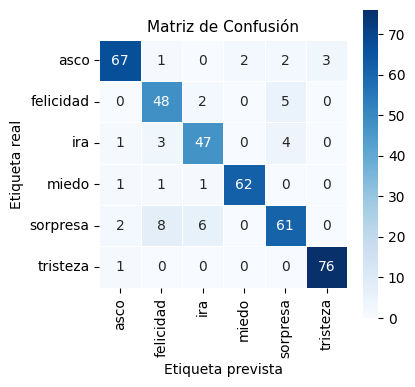

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(cmGB_prob, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
plt.title('Matriz de Confusión', size=11)
plt.ylabel('Etiqueta real');
plt.xlabel('Etiqueta prevista');
all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy_prob)
plt.show()

In [ ]:
# Calcular la matriz de confusión
mcGB = confusion_matrix(y_test, prediccionGB_emocion)

# Calcular el porcentaje de acierto para cada etiqueta
accuracy_per_classGB = mcGB.diagonal() / mcGB.sum(axis=1)

# Imprimir el porcentaje de acierto para cada etiqueta
for i, acc in enumerate(accuracy_per_classGB):
    print(f'Precisión para la clase {mapeo_emociones[i]}: {acc:.2%}')

Precisión para la clase asco: 89.33%
Precisión para la clase felicidad: 87.27%
Precisión para la clase ira: 85.45%
Precisión para la clase miedo: 95.38%
Precisión para la clase sorpresa: 79.22%
Precisión para la clase tristeza: 98.70%


In [ ]:
# Informe de clasificación
informe_clasificacion_GB = classification_report(y_test, prediccionGB_emocion)
print("Informe de Clasificación:")
print(informe_clasificacion_GB)

Informe de Clasificación:
              precision    recall  f1-score   support

        asco       0.93      0.89      0.91        75
   felicidad       0.79      0.87      0.83        55
         ira       0.84      0.85      0.85        55
       miedo       0.97      0.95      0.96        65
    sorpresa       0.85      0.79      0.82        77
    tristeza       0.96      0.99      0.97        77

    accuracy                           0.89       404
   macro avg       0.89      0.89      0.89       404
weighted avg       0.89      0.89      0.89       404



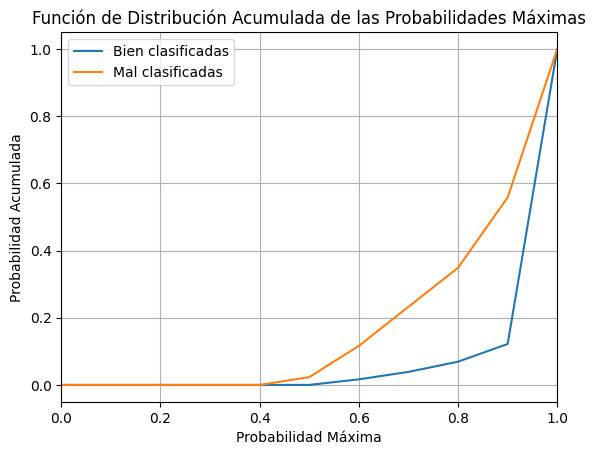

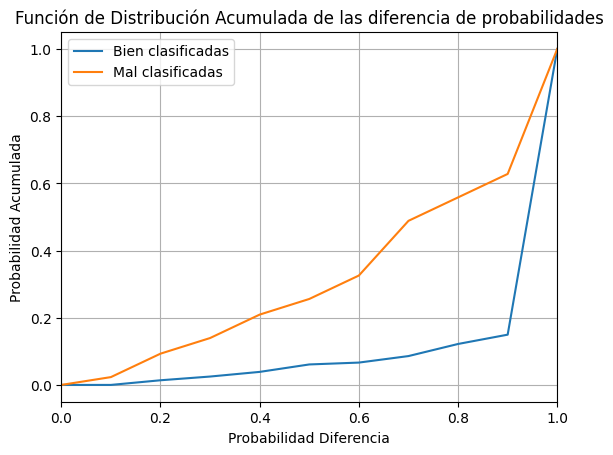

In [ ]:
cdf_Probmax(prediccionesGB_prob, prediccionGB_emocion, y_test_flat)
cdf_Probdif(prediccionesGB_prob, prediccionGB_emocion, y_test_flat)

In [ ]:
ThMax_GB = 0.5
ThDif_GB = 0.1
prediccionesGB_ConUn, X_testGB_ConUn, Y_testGB_ConUn, perdidasGB_ConUn, perdidasGB_malas_ConUn = ClaseUnknown(prediccionesGB_prob,prediccionGB_emocion, x_test_scaled, y_test_flat, ThMax_GB, ThDif_GB)

prediccionesGB_Ignorando, X_testGB_Ignorando, Y_testGB_Ignorando, perdidasGB_Ignorando, perdidasGB_malas_Ignorando, biendentroGB = DescartaFueraUmbral(prediccionesGB_prob,prediccionGB_emocion, x_test_scaled, y_test_flat, ThMax_GB, ThDif_GB)


In [ ]:
accuracyGB_ConUn = accuracy_score(Y_testGB_ConUn,prediccionesGB_ConUn)
print("")
print(f"El accuracy (creando Unknown) para ThprobMax={ThMax_GB} y Thdif={ThDif_GB} es: {100*accuracyGB_ConUn}%, \npero se tienen {perdidasGB_ConUn} perdidas de datos bien clasificados y {perdidasGB_malas_ConUn} perdidas de datos mal clasificados")

print("")
accuracyGB_Ignorando = accuracy_score(Y_testGB_Ignorando,prediccionesGB_Ignorando)
print(f"El accuracy (ignorando muestras fuera umbral) para ThprobMax={ThMax_GB} y Thdif={ThDif_GB} es: {100*accuracyGB_Ignorando}%, \npero se tienen {perdidasGB_Ignorando} perdidas de datos bien clasificados y {perdidasGB_malas_Ignorando} perdidas de datos mal clasificados")



El accuracy (creando Unknown) para ThprobMax=0.5 y Thdif=0.1 es: 88.61386138613861%, 
pero se tienen 1 perdidas de datos bien clasificados y 4 perdidas de datos mal clasificados

El accuracy (ignorando muestras fuera umbral) para ThprobMax=0.5 y Thdif=0.1 es: 89.72431077694235%, 
pero se tienen 1 perdidas de datos bien clasificados y 4 perdidas de datos mal clasificados


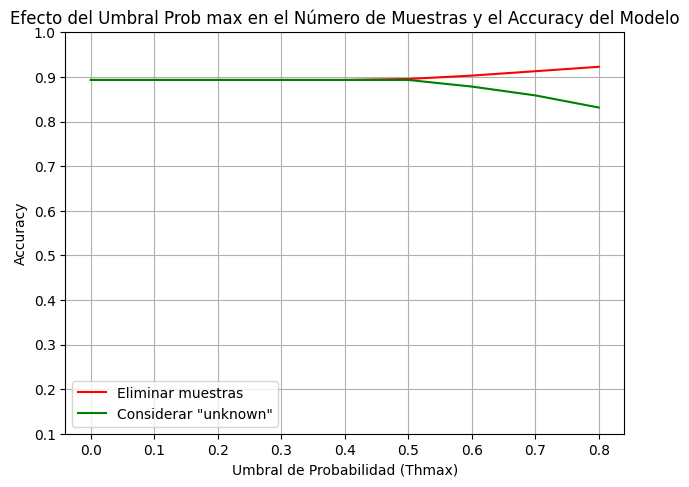

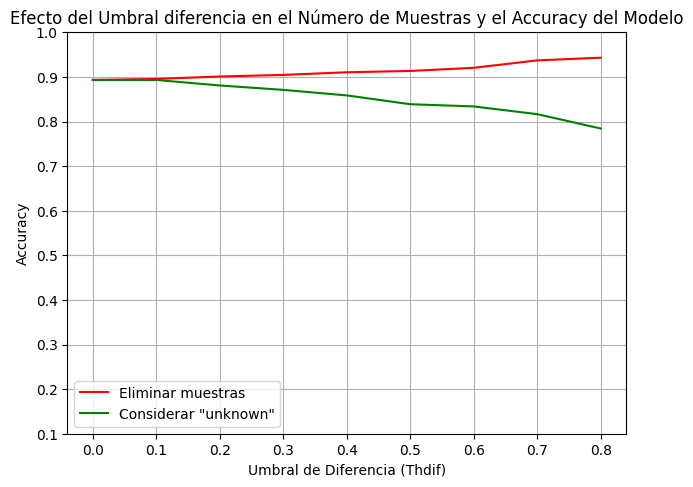

In [ ]:
calcular_accuracy_umbral_Prob(prediccionesGB_prob, prediccionGB_emocion, x_test_scaled, y_test_flat, Thmax_range)
calcular_accuracy_umbral_Dif(prediccionesGB_prob, prediccionGB_emocion, x_test_scaled, y_test_flat, Thdif_range)

## RF

In [ ]:
param_grid_RF = {
    'n_estimators': [100, 150,200],
    'max_features':["auto", "sqrt", "log2", 0.5, 0.7, 1.0],
    'max_depth'   : [None, 3, 10, 20],
    'criterion'   : ['gini', 'entropy']
}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid_RF = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 0),
        param_grid = param_grid_RF,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = stratified_kfold,
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid_RF.fit(X = x_train_scaled, y = y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.7,
                                          1.0],
                         'n_estimators': [100, 150, 200]},
             return_train_score=True, scoring='accuracy')

In [ ]:
# Resultados# ==============================================================================
resultados_RF = pd.DataFrame(grid_RF.cv_results_)
resultados_RF.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

param_criterion param_max_depth param_max_features param_n_estimators  \
56            gini              20               auto                200   
59            gini              20               sqrt                200   
2             gini            None               auto                200   
5             gini            None               sqrt                200   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
56         0.886349         0.02339               1.0              0.0  
59         0.886349         0.02339               1.0              0.0  
2          0.885286         0.02423               1.0              0.0  
5          0.885286         0.02423               1.0              0.0

In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (RF) (cv)")
print("----------------------------------------")
print(grid_RF.best_params_, ":", grid_RF.best_score_, grid_RF.scoring)

modelo_RF = grid_RF.best_estimator_
# predicciones_RF = modelo_RF.predict(x_test_scaled)

----------------------------------------
Mejores hiperparámetros encontrados (RF) (cv)
----------------------------------------
{'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 200} : 0.8863493840985444 accuracy


In [ ]:
prediccionesRF_prob = modelo_RF.predict_proba(x_test_scaled_contest) #y_prob
prediccionRF_emocion = []

for i in range(len(X_test)):
  probabilidades_predichasRF = prediccionesRF_prob[i]
  emocionRF_prediccion = np.argmax(probabilidades_predichasRF)
  prediccionRF_emocion.append(mapeo_emociones[emocionRF_prediccion])

  # if y_test_flat[i] != prediccion_emocion[i]:
  #   print("hola")

prediccionRF_emocion = np.array(prediccionRF_emocion)

In [ ]:
# Accuracy
# ==============================================================================
accuracy_RF = accuracy_score(
            y_true    = y_test,
            y_pred    = prediccionRF_emocion,
            normalize = True # =False --> devuelve el numero de las acertadas
           )
print("")
print(f"RF: El accuracy de test es: {100*accuracy_RF}%")


RF: El accuracy de test es: 87.62376237623762%


In [ ]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix_RF = pd.crosstab(
    np.ravel(y_test),
    prediccionRF_emocion,
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix_RF

Predicción  asco  felicidad  ira  miedo  sorpresa  tristeza
Real                                                       
asco          62          1    0      2         5         5
felicidad      0         51    1      0         3         0
ira            1          2   49      0         3         0
miedo          2          2    0     59         1         1
sorpresa       2         10    0      1        64         0
tristeza       2          0    0      6         0        69

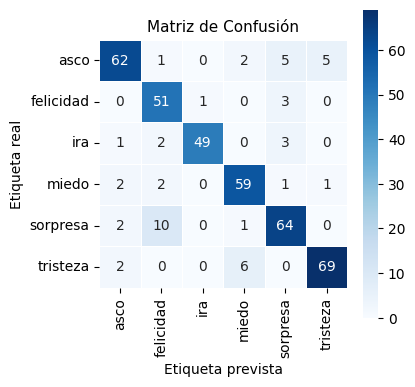

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix_RF, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
plt.title('Matriz de Confusión', size=11)
plt.ylabel('Etiqueta real');
plt.xlabel('Etiqueta prevista');
all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy_prob)
plt.show()

In [ ]:
# Calcular la matriz de confusión
mcRF= confusion_matrix(y_test, prediccionRF_emocion)

# Calcular el porcentaje de acierto para cada etiqueta
accuracy_per_classRF = mcRF.diagonal() / mcRF.sum(axis=1)

# Imprimir el porcentaje de acierto para cada etiqueta
for i, acc in enumerate(accuracy_per_classRF):
    print(f'Precisión para la clase {mapeo_emociones[i]}: {acc:.2%}')

Precisión para la clase asco: 82.67%
Precisión para la clase felicidad: 92.73%
Precisión para la clase ira: 89.09%
Precisión para la clase miedo: 90.77%
Precisión para la clase sorpresa: 83.12%
Precisión para la clase tristeza: 89.61%


In [ ]:
# Informe de clasificación
informe_clasificacion_RF = classification_report(y_test, prediccionRF_emocion)
print("Informe de Clasificación:")
print(informe_clasificacion_RF)

Informe de Clasificación:
              precision    recall  f1-score   support

        asco       0.90      0.83      0.86        75
   felicidad       0.77      0.93      0.84        55
         ira       0.98      0.89      0.93        55
       miedo       0.87      0.91      0.89        65
    sorpresa       0.84      0.83      0.84        77
    tristeza       0.92      0.90      0.91        77

    accuracy                           0.88       404
   macro avg       0.88      0.88      0.88       404
weighted avg       0.88      0.88      0.88       404



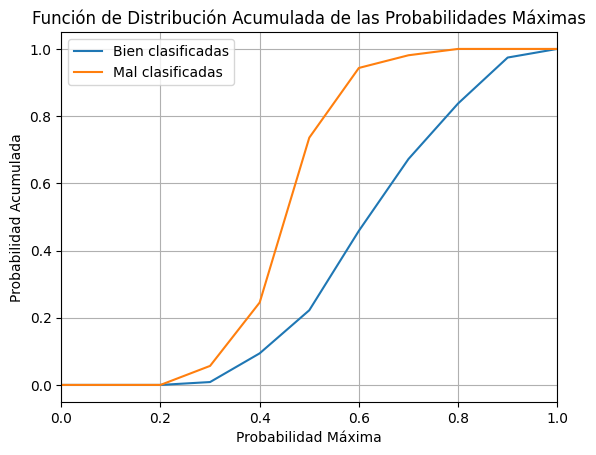

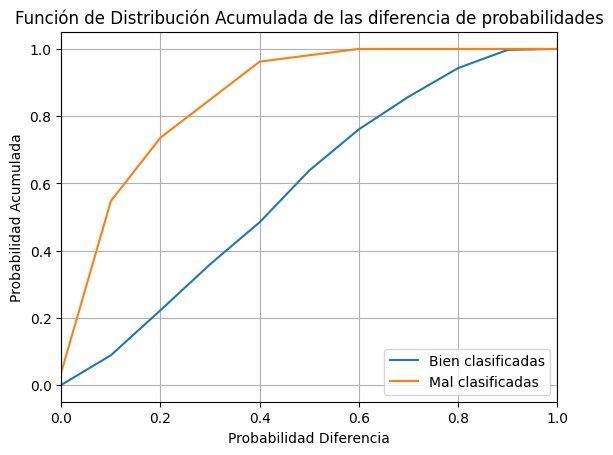

In [ ]:
cdf_Probmax(prediccionesRF_prob, prediccionRF_emocion, y_test_flat)
cdf_Probdif(prediccionesRF_prob, prediccionRF_emocion, y_test_flat)

In [ ]:
ThMax_RF = 0.0
ThDif_RF = 0.0
prediccionesRF_ConUn, X_testRF_ConUn, Y_testRF_ConUn, perdidasRF_ConUn, perdidasRF_malas_ConUn = ClaseUnknown(prediccionesRF_prob,prediccionRF_emocion, x_test_scaled, y_test_flat, ThMax_RF, ThDif_RF)

prediccionesRF_Ignorando, X_testRF_Ignorando, Y_testRF_Ignorando, perdidasRF_Ignorando, perdidasRF_malas_Ignorando, biendentroRF = DescartaFueraUmbral(prediccionesRF_prob,prediccionRF_emocion, x_test_scaled, y_test_flat, ThMax_RF, ThDif_RF)


In [ ]:
accuracyRF_ConUn = accuracy_score(Y_testRF_ConUn,prediccionesRF_ConUn)
print("")
print(f"El accuracy (creando Unknown) para ThprobMax={ThMax_RF} y Thdif={ThDif_RF} es: {100*accuracyRF_ConUn}%, \npero se tienen {perdidasRF_ConUn} perdidas de datos bien clasificados y {perdidasRF_malas_ConUn} perdidas de datos mal clasificados")

print("")
accuracyRF_Ignorando = accuracy_score(Y_testRF_Ignorando,prediccionesRF_Ignorando)
print(f"El accuracy (ignorando muestras fuera umbral) para ThprobMax={ThMax_RF} y Thdif={ThDif_RF} es: {100*accuracyRF_Ignorando}%, \npero se tienen {perdidasRF_Ignorando} perdidas de datos bien clasificados y {perdidasRF_malas_Ignorando} perdidas de datos mal clasificados")



El accuracy (creando Unknown) para ThprobMax=0.0 y Thdif=0.0 es: 86.88118811881188%, 
pero se tienen 0 perdidas de datos bien clasificados y 2 perdidas de datos mal clasificados

El accuracy (ignorando muestras fuera umbral) para ThprobMax=0.0 y Thdif=0.0 es: 87.31343283582089%, 
pero se tienen 0 perdidas de datos bien clasificados y 2 perdidas de datos mal clasificados


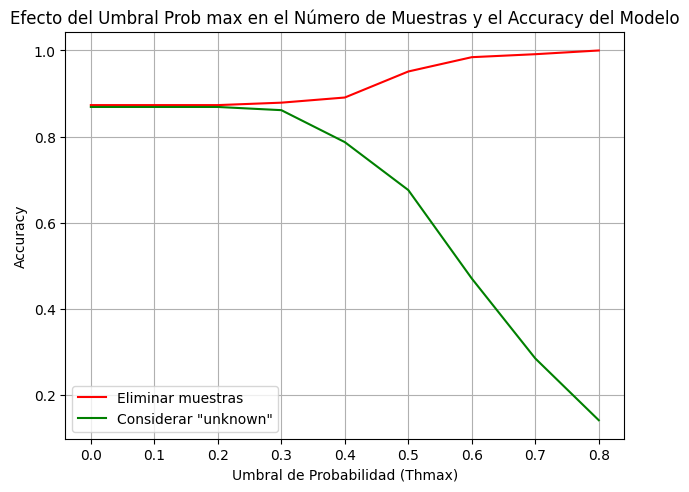

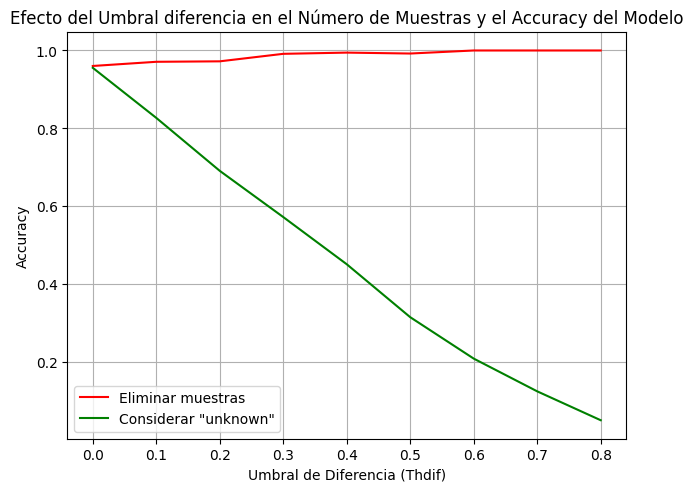

In [ ]:
calcular_accuracy_umbral_Prob(prediccionesRF_prob, prediccionRF_emocion, x_test_scaled, y_test_flat, Thmax_range)
calcular_accuracy_umbral_Dif(prediccionesRF_prob, prediccionRF_emocion, x_test_scaled, y_test_flat, Thdif_range)

# Crema-D --> test

In [ ]:
Crema = '/content/drive/MyDrive/TFG/AudioWAV/'

In [ ]:
CremaAudios = os.listdir(Crema)

file_emotion_Cr = [] #Almacena emocion
file_path_Cr= []    #Almacena ruta del archivo de audio
contador = 0

for files in CremaAudios:
    file_path_Cr.append(Crema + files)  #Para cada file, crea ruta con rutaCarpeta+NombreArchivoAudio

    part=files.split('_')  #Divide nombre archivo --> ['1001', 'DFA', 'SAD', 'XX.wav'] --> Tercera parte indica emoción
    # if part[3] == 'LO.wav' or part[3] == 'HI.wav':
    #   contador = contador +1
    #   ruta='/content/drive/MyDrive/TFG/AudioWAV/' + files
    #   os.unlink(ruta)
    if part[2] == 'SAD':
      file_emotion_Cr.append('tristeza')
    elif part[2] == 'ANG':
      file_emotion_Cr.append('ira')
    elif part[2] == 'DIS':
      file_emotion_Cr.append('asco')
    elif part[2] == 'FEA':
      file_emotion_Cr.append('miedo')
    elif part[2] == 'HAP':
      file_emotion_Cr.append('felicidad')
    # elif part[2] == 'NEU':
    #   # file_emotion_Cr.append('neutral')
    #   ruta='/content/drive/MyDrive/TFG/AudioWAV/' + files
    #   os.unlink(ruta)
    #   # BIEN
    else:
      file_emotion_Cr.append('Unknown')


# dataframe para emociones --> 1 coluna llamada Emotions con las emociones
emotion_Cr = pd.DataFrame(file_emotion_Cr, columns=['Emotions'])
print(contador)

# dataframepara path
path_Crema = pd.DataFrame(file_path_Cr, columns=['Path'])
Crema_df = pd.concat([emotion_Cr, path_Crema], axis=1)
Crema_df


0


Emotions                                               Path
0          asco  /content/drive/MyDrive/TFG/AudioWAV/1075_IWL_D...
1     felicidad  /content/drive/MyDrive/TFG/AudioWAV/1075_ITH_H...
2           ira  /content/drive/MyDrive/TFG/AudioWAV/1075_ITH_A...
3         miedo  /content/drive/MyDrive/TFG/AudioWAV/1075_ITS_F...
4           ira  /content/drive/MyDrive/TFG/AudioWAV/1075_ITS_A...
...         ...                                                ...
5439        ira  /content/drive/MyDrive/TFG/AudioWAV/1008_IWL_A...
5440       asco  /content/drive/MyDrive/TFG/AudioWAV/1008_IOM_D...
5441      miedo  /content/drive/MyDrive/TFG/AudioWAV/1008_ITH_F...
5442   tristeza  /content/drive/MyDrive/TFG/AudioWAV/1008_ITS_S...
5443        ira  /content/drive/MyDrive/TFG/AudioWAV/1008_ITS_A...

[5444 rows x 2 columns]

from matplotlib import pyplot as plt
import seaborn as sns
Crema_df.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

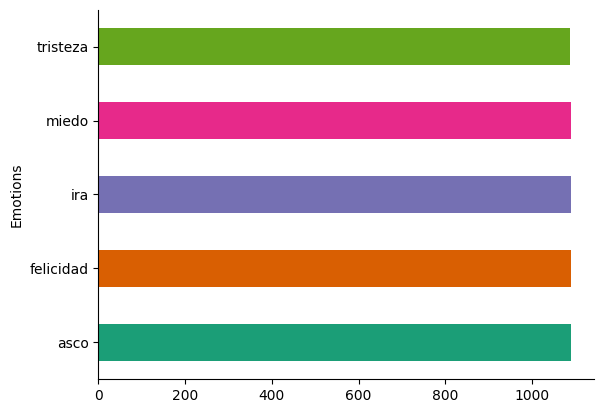

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
Crema_df.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
allFeaturesCrema = FeatureExtraction(Crema_df)

In [ ]:
scaler_crema = StandardScaler()
scaler_crema.fit(allFeaturesCrema)
allFeaturesCrema_scaled = scaler_crema.transform(allFeaturesCrema) #Escalamos con ella misma

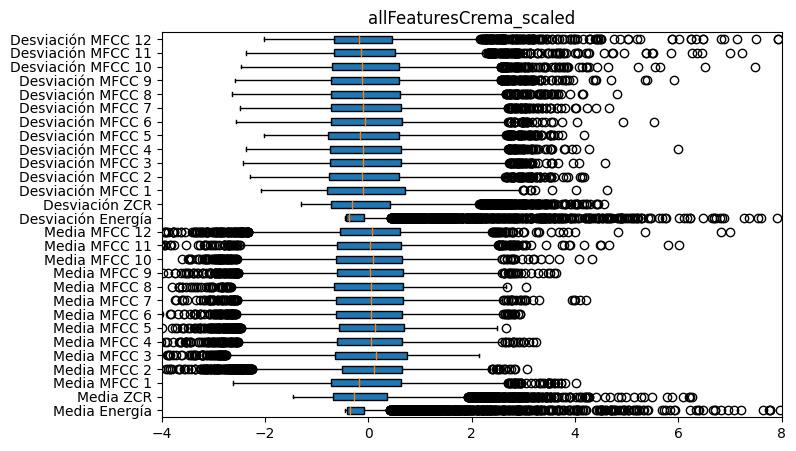

In [ ]:
num_features = len(allFeaturesCrema_scaled[0])

plt.figure(figsize=(8, 5))  # Tamaño de la figura

# Crear un boxplot para cada característica
plt.boxplot(allFeaturesCrema_scaled, vert=False, patch_artist=True)

# Configurar etiquetas y título
# plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
plt.yticks(range(1, num_features + 1), feature_names)
plt.title('allFeaturesCrema_scaled')
plt.xlim([-4,8])
# Mostrar la figura
plt.show()

In [ ]:
# #ETIQUETAS NUMERICAS
# label_encoder_crema = LabelEncoder()
# emotion_Cr_encoded = label_encoder_crema.fit_transform(emotion_Cr)

# # Obtener la relación entre las emociones originales y los números asignados
# relacion_emociones_numeros_cd = dict(zip(label_encoder_crema.classes_, range(len(label_encoder_crema.classes_))))

# # Mostrar la relación
# print(relacion_emociones_numeros_cd)

In [ ]:
# allFeaturesCrema_scaled = scaler_train.transform(allFeaturesCrema) #Escalamos con X_train
# emotion_Cr_encoded = label_encoder.fit_transform(emotion_Cr) #Codificamos etiquetas

In [ ]:
# predicciones_Cr = modelo.predict(allFeaturesCrema_scaled) #Predicciones (todos datos son de test)

ravel_emotion_Cr = np.ravel(emotion_Cr)
prediccionesCr_prob = modelo.predict_proba(allFeaturesCrema_scaled)
predicciones_Cr = []

for i in range(len(prediccionesCr_prob)):
  probabilidadesCr_predichas = prediccionesCr_prob[i]
  emocionCr_prediccion = np.argmax(probabilidadesCr_predichas)
  predicciones_Cr.append(mapeo_emociones[emocionCr_prediccion])

  # if y_test_flat[i] != prediccion_emocion[i]:
  #   print("hola")

predicciones_Cr = np.array(predicciones_Cr)

In [ ]:
accuracy_Cr = accuracy_score(
            y_true    = ravel_emotion_Cr,
            y_pred    = predicciones_Cr,
            normalize = True # =False --> devuelve el numero de las acertadas
           )
print("")
print(f"El accuracy de test es: {100*accuracy_Cr}%")


El accuracy de test es: 32.69654665686995%


In [ ]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix_Cr = pd.crosstab(
    ravel_emotion_Cr,
    predicciones_Cr,
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix_Cr

Predicción  asco  felicidad  ira  miedo  sorpresa  tristeza
Real                                                       
asco         475         52   90    203       118       151
felicidad    278        143  173    203       237        55
ira          135        229  453     29       232        11
miedo        326         87   89    241       114       232
tristeza     265         15    6    305        29       468

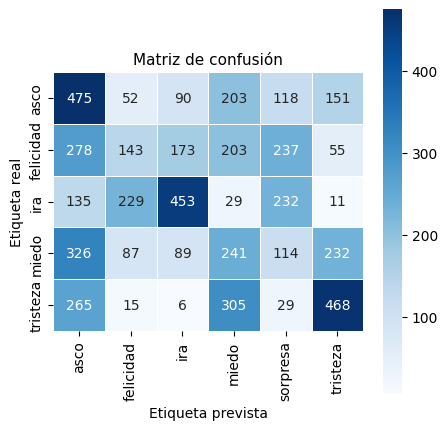

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_Cr, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
plt.title('Matriz de confusión', size=11)
plt.ylabel('Etiqueta real');
plt.xlabel('Etiqueta prevista');
all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy_Cr)
plt.show()

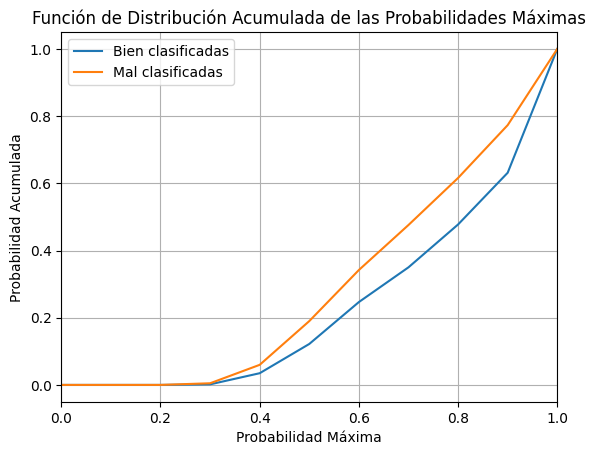

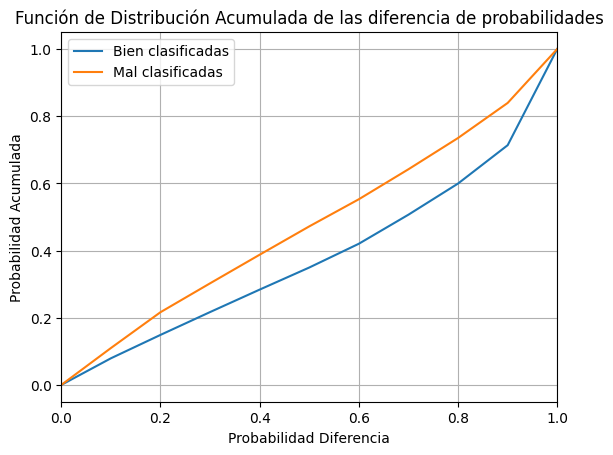

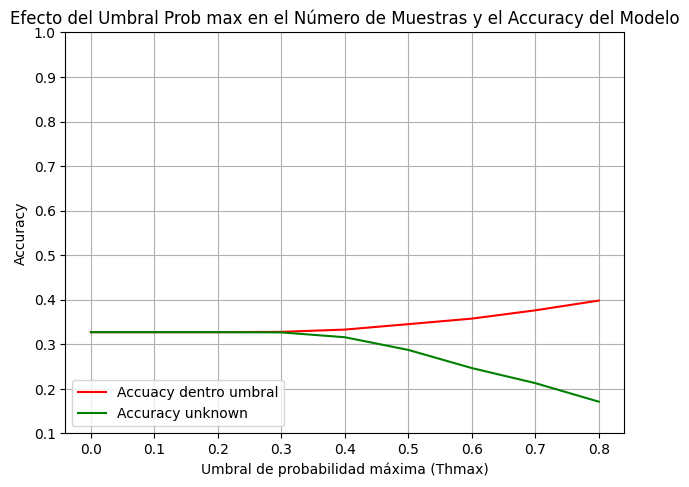

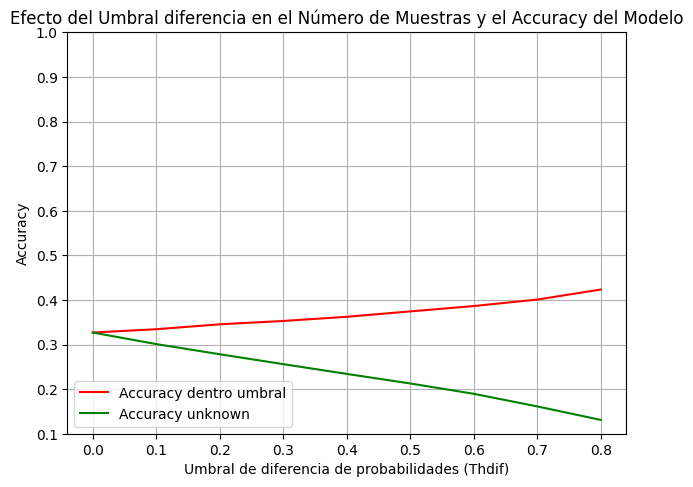

In [ ]:
cdf_Probmax(prediccionesCr_prob, predicciones_Cr, ravel_emotion_Cr)
cdf_Probdif(prediccionesCr_prob, predicciones_Cr, ravel_emotion_Cr)

Thmax_range = np.arange(0.0, 0.9, 0.1)
Thdif_range = np.arange(0.0, 0.9, 0.1)

calcular_accuracy_umbral_Prob(prediccionesCr_prob, predicciones_Cr, allFeaturesCrema_scaled, ravel_emotion_Cr, Thmax_range)
calcular_accuracy_umbral_Dif(prediccionesCr_prob, predicciones_Cr, allFeaturesCrema_scaled, ravel_emotion_Cr, Thdif_range)

In [ ]:
ThMax_Cr = 0.4
ThDif_Cr = 0.0
prediccionesCr_ConUn, X_testCr_ConUn, Y_testCr_ConUn, perdidasCr_ConUn, perdidasCr_malas_ConUn = ClaseUnknown(prediccionesCr_prob,predicciones_Cr, allFeaturesCrema_scaled, ravel_emotion_Cr, ThMax_Cr, ThDif_Cr)

prediccionesCr_Ignorando, X_testCr_Ignorando, Y_testCr_Ignorando, perdidasCr_Ignorando, perdidasCr_malas_Ignorando, biendentroCr = DescartaFueraUmbral(prediccionesCr_prob, predicciones_Cr, allFeaturesCrema_scaled, ravel_emotion_Cr, ThMax_Cr, ThDif_Cr)

accuracyCr_ConUn = accuracy_score(Y_testCr_ConUn,prediccionesCr_ConUn)
print("")
print(f"El accuracy (creando Unknown) para ThprobMax={ThMax_Cr} y Thdif={ThDif_Cr} es: {100*accuracyCr_ConUn}%, \npero se tienen {perdidasCr_ConUn} perdidas de datos bien clasificados y {perdidasCr_malas_ConUn} perdidas de datos mal clasificados")

print("")
accuracyCr_Ignorando = accuracy_score(Y_testCr_Ignorando,prediccionesCr_Ignorando)
print(f"El accuracy (ignorando muestras fuera umbral) para ThprobMax={ThMax_Cr} y Thdif={ThDif_Cr} es: {100*accuracyCr_Ignorando}%, \npero se tienen {perdidasCr_Ignorando} perdidas de datos bien clasificados y {perdidasCr_malas_Ignorando} perdidas de datos mal clasificados")



El accuracy (creando Unknown) para ThprobMax=0.4 y Thdif=0.0 es: 31.557678177810434%, 
pero se tienen 62 perdidas de datos bien clasificados y 219 perdidas de datos mal clasificados

El accuracy (ignorando muestras fuera umbral) para ThprobMax=0.4 y Thdif=0.0 es: 33.275227580863834%, 
pero se tienen 62 perdidas de datos bien clasificados y 219 perdidas de datos mal clasificados


In [ ]:
# Calcular la matriz de confusión
mc_Cr = confusion_matrix(emotion_Cr, predicciones_Cr)

# Calcular el porcentaje de acierto para cada etiqueta
# axis=0 --> columna fila axis=1 --> fila
accuracy_per_class_Cr = mc_Cr.diagonal() / mc_Cr.sum(axis=1)
accuracy_per_class_Cr[4] = mc_Cr[4, 5] / mc_Cr[4, :].sum()


# Imprimir el porcentaje de acierto para cada etiqueta
for i, acc in enumerate(accuracy_per_class_Cr):
    if not np.isnan(acc):
        print(f'Precisión para la clase {mapeo_emociones[i]}: {acc:.2%}')
    else:
        print(f'No hay predicciones para la clase {mapeo_emociones[i]}')

Precisión para la clase asco: 43.62%
Precisión para la clase felicidad: 13.13%
Precisión para la clase ira: 41.60%
Precisión para la clase miedo: 22.13%
No hay predicciones para la clase sorpresa
Precisión para la clase tristeza: 43.01%


<ipython-input-51-2b50e600ea87>:6: RuntimeWarning: invalid value encountered in divide
  accuracy_per_class_Cr = mc_Cr.diagonal() / mc_Cr.sum(axis=1)
<ipython-input-51-2b50e600ea87>:7: RuntimeWarning: invalid value encountered in long_scalars
  accuracy_per_class_Cr[4] = mc_Cr[4, 5] / mc_Cr[4, :].sum()


# Diagrama bigote gato

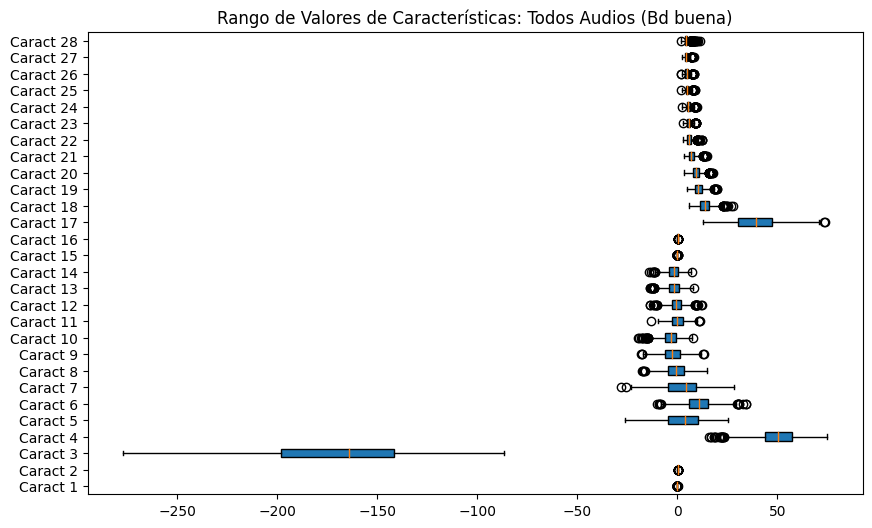

In [ ]:
num_features = len(allFeatures[0])

plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Crear un boxplot para cada característica
plt.boxplot(allFeatures, vert=False, patch_artist=True)

# Configurar etiquetas y título
plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
plt.title('Rango de Valores de Características: Todos Audios (Bd buena)')
# Mostrar la figura
plt.show()


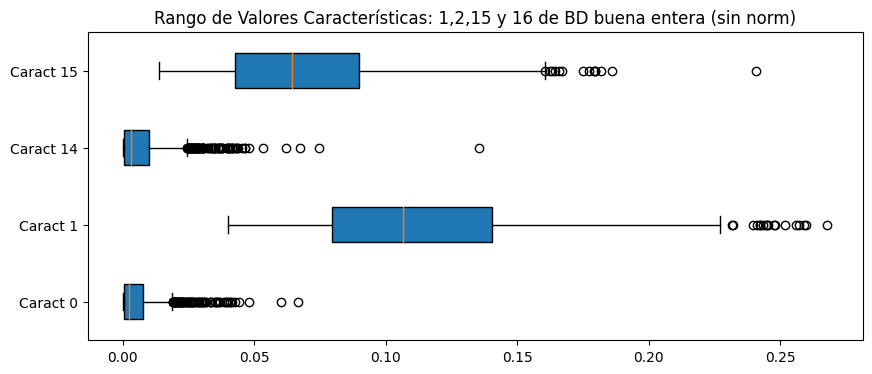

In [ ]:
# selected_features = allFeatures[:, :2]
selected_features = allFeatures[:, [0, 1, 14, 15]]

plt.figure(figsize=(10, 4))  # Reducir la altura de la figura para mostrar solo dos características

# Crear un boxplot para las dos primeras características
plt.boxplot(selected_features, vert=False, patch_artist=True)

# Configurar etiquetas y título
# plt.yticks([1, 2], ['Caract 1', 'Caract 2'])
plt.yticks([1, 2, 3, 4], ['Caract 0', 'Caract 1', 'Caract 14', 'Caract 15'])
plt.title('Rango de Valores Características: 1,2,15 y 16 de BD buena entera (sin norm)')

# Mostrar la figura
plt.show()

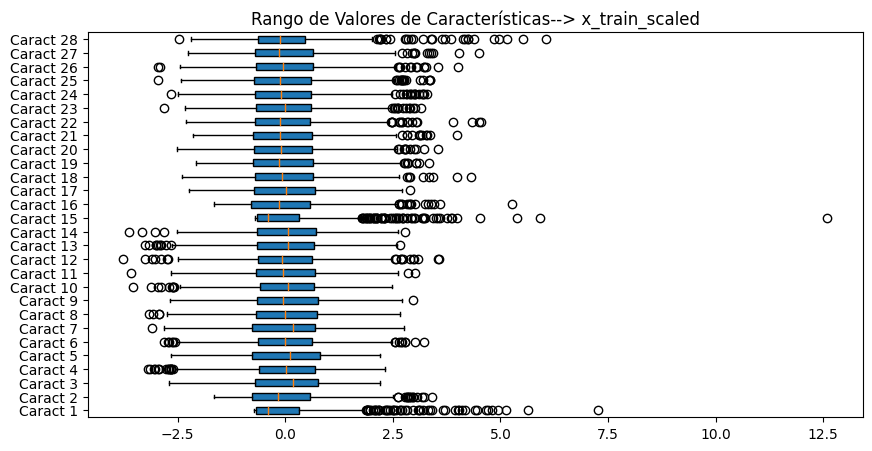

In [ ]:
num_features = len(x_train_scaled[0])

plt.figure(figsize=(10, 5))  # Tamaño de la figura

# Crear un boxplot para cada característica
plt.boxplot(x_train_scaled, vert=False, patch_artist=True)

# Configurar etiquetas y título
plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
plt.title('Rango de Valores de Características--> x_train_scaled')
# Mostrar la figura
plt.show()

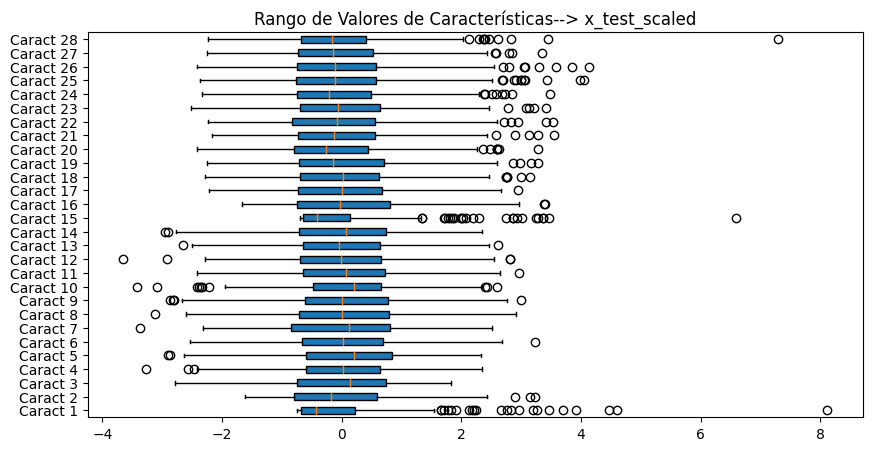

In [ ]:
num_features = len(x_test_scaled[0])

plt.figure(figsize=(10, 5))  # Tamaño de la figura

# Crear un boxplot para cada característica
plt.boxplot(x_test_scaled, vert=False, patch_artist=True)

# Configurar etiquetas y título
plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
plt.title('Rango de Valores de Características--> x_test_scaled')
# Mostrar la figura
plt.show()

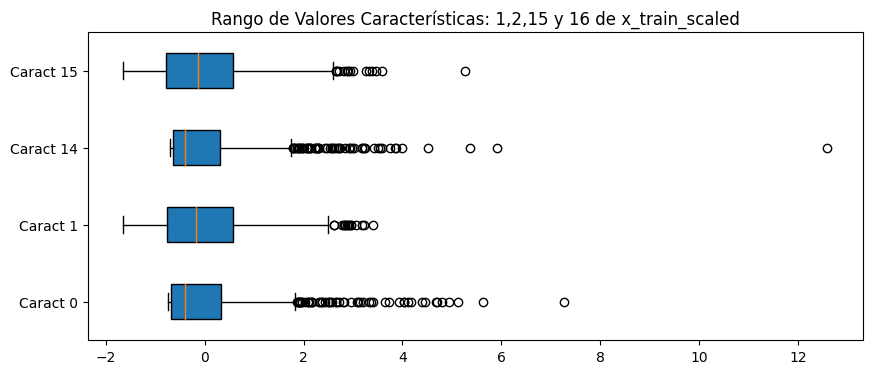

In [ ]:

selected_features = x_train_scaled[:, [0, 1, 14, 15]]

plt.figure(figsize=(10, 4))  # Reducir la altura de la figura para mostrar solo dos características

# Crear un boxplot para las dos primeras características
plt.boxplot(selected_features, vert=False, patch_artist=True)

# Configurar etiquetas y título
# plt.yticks([1, 2], ['Caract 1', 'Caract 2'])
plt.yticks([1, 2, 3, 4], ['Caract 0', 'Caract 1', 'Caract 14', 'Caract 15'])
plt.title('Rango de Valores Características: 1,2,15 y 16 de x_train_scaled')

# Mostrar la figura
plt.show()

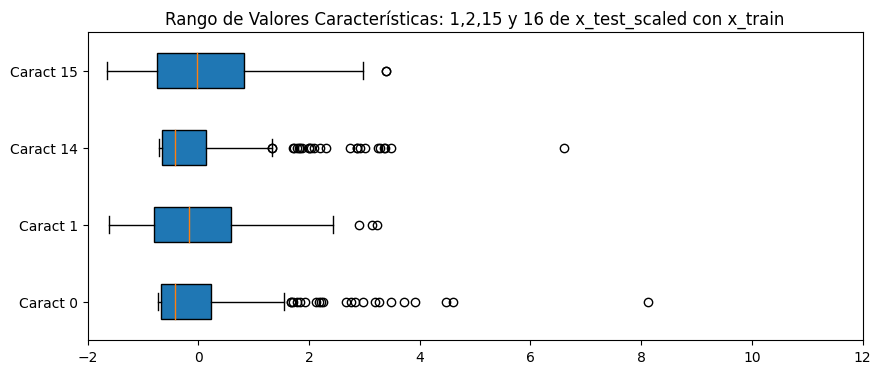

In [ ]:

selected_features = x_test_scaled[:, [0, 1, 14, 15]]

plt.figure(figsize=(10, 4))  # Reducir la altura de la figura para mostrar solo dos características

# Crear un boxplot para las dos primeras características
plt.boxplot(selected_features, vert=False, patch_artist=True)

# Configurar etiquetas y título
# plt.yticks([1, 2], ['Caract 1', 'Caract 2'])
plt.yticks([1, 2, 3, 4], ['Caract 0', 'Caract 1', 'Caract 14', 'Caract 15'])
plt.title('Rango de Valores Características: 1,2,15 y 16 de x_test_scaled con x_train')
plt.xlim([-2,12])
# Mostrar la figura
plt.show()

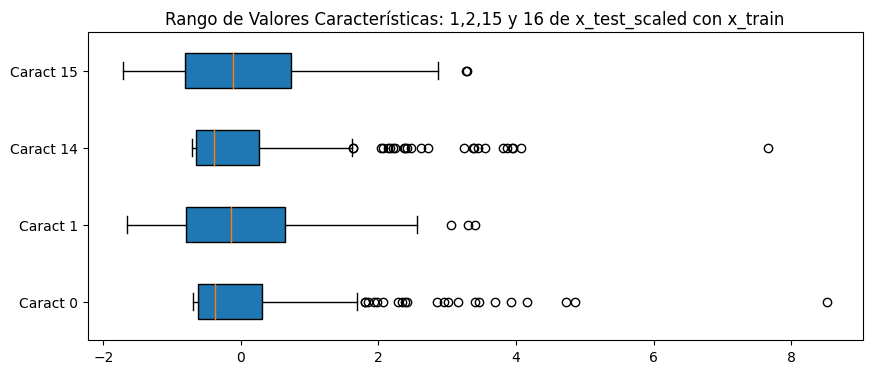

In [ ]:

selected_features_contest = x_test_scaled_contest[:, [0, 1, 14, 15]]

plt.figure(figsize=(10, 4))  # Reducir la altura de la figura para mostrar solo dos características

# Crear un boxplot para las dos primeras características
plt.boxplot(selected_features_contest, vert=False, patch_artist=True)

# Configurar etiquetas y título
# plt.yticks([1, 2], ['Caract 1', 'Caract 2'])
plt.yticks([1, 2, 3, 4], ['Caract 0', 'Caract 1', 'Caract 14', 'Caract 15'])
plt.title('Rango de Valores Características: 1,2,15 y 16 de x_test_scaled con x_train')

# Mostrar la figura
plt.show()

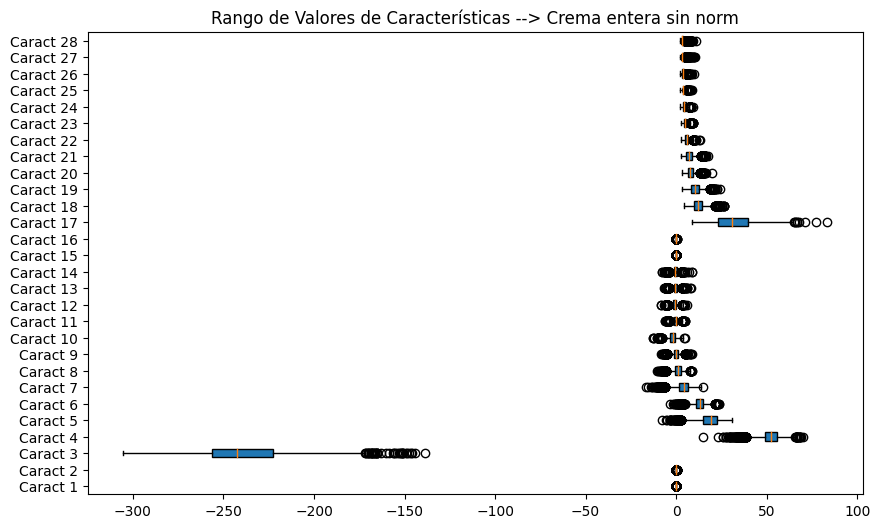

In [ ]:
num_features = len(allFeaturesCrema[0])

plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Crear un boxplot para cada característica
plt.boxplot(allFeaturesCrema, vert=False, patch_artist=True)

# Configurar etiquetas y título
plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
plt.title('Rango de Valores de Características --> Crema entera sin norm')
# Mostrar la figura
plt.show()

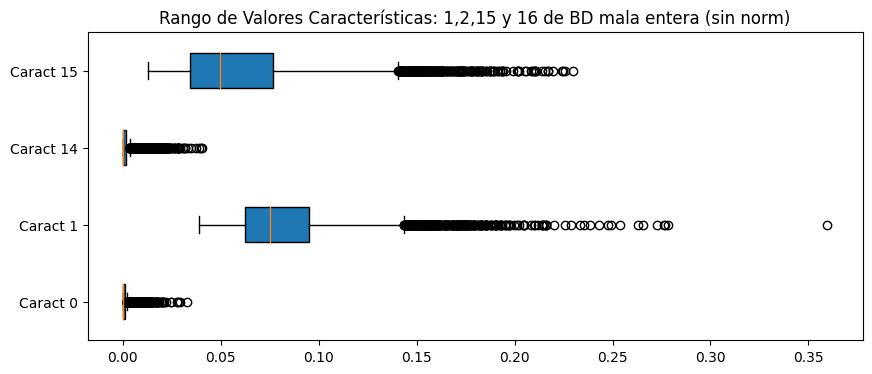

In [ ]:
selected_features_Cr = allFeaturesCrema[:, [0, 1, 14, 15]]

plt.figure(figsize=(10, 4))  # Reducir la altura de la figura para mostrar solo dos características

# Crear un boxplot para las dos primeras características
plt.boxplot(selected_features_Cr, vert=False, patch_artist=True)

# Configurar etiquetas y título
# plt.yticks([1, 2], ['Caract 1', 'Caract 2'])
plt.yticks([1, 2, 3, 4], ['Caract 0', 'Caract 1', 'Caract 14', 'Caract 15'])
plt.title('Rango de Valores Características: 1,2,15 y 16 de BD mala entera (sin norm)')

# Mostrar la figura
plt.show()

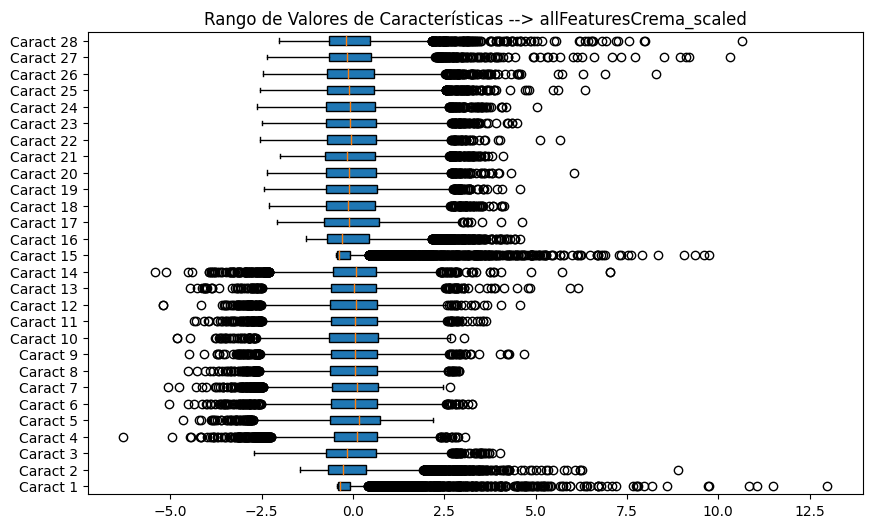

In [ ]:
num_features = len(allFeaturesCrema_scaled[0])

plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Crear un boxplot para cada característica
plt.boxplot(allFeaturesCrema_scaled, vert=False, patch_artist=True)

# Configurar etiquetas y título
plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
plt.title('Rango de Valores de Características --> allFeaturesCrema_scaled')
# Mostrar la figura
plt.show()

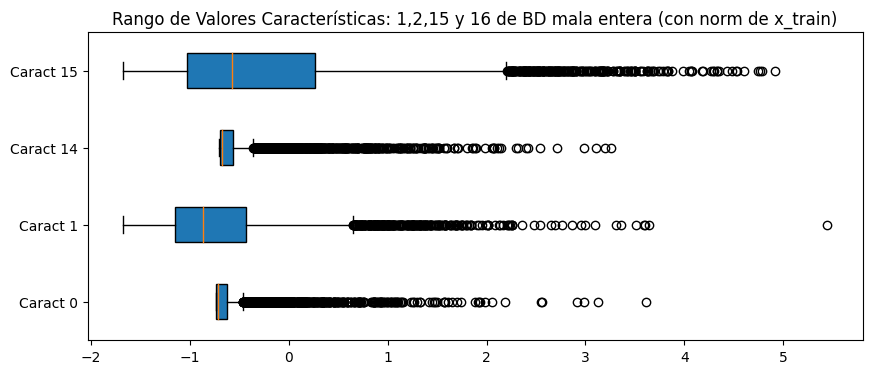

In [ ]:
selected_features_Cr = allFeaturesCrema_scaled[:, [0, 1, 14, 15]]

plt.figure(figsize=(10, 4))  # Reducir la altura de la figura para mostrar solo dos características

# Crear un boxplot para las dos primeras características
plt.boxplot(selected_features_Cr, vert=False, patch_artist=True)

# Configurar etiquetas y título
# plt.yticks([1, 2], ['Caract 1', 'Caract 2'])
plt.yticks([1, 2, 3, 4], ['Caract 0', 'Caract 1', 'Caract 14', 'Caract 15'])
plt.title('Rango de Valores Características: 1,2,15 y 16 de BD mala entera (con norm de x_train)')

# Mostrar la figura
plt.show()

# Histograma

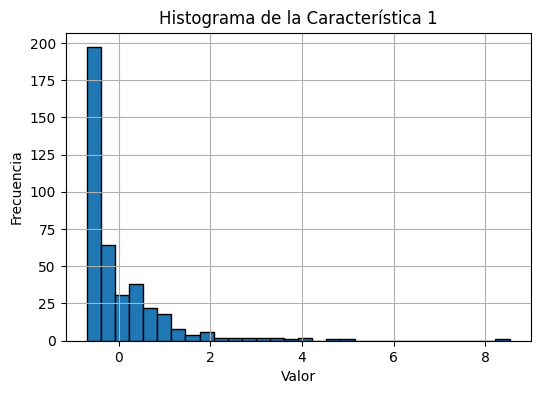

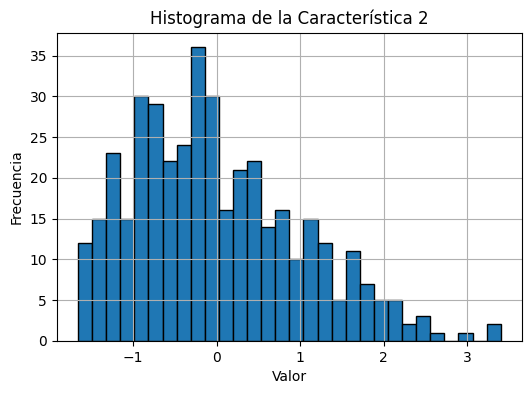

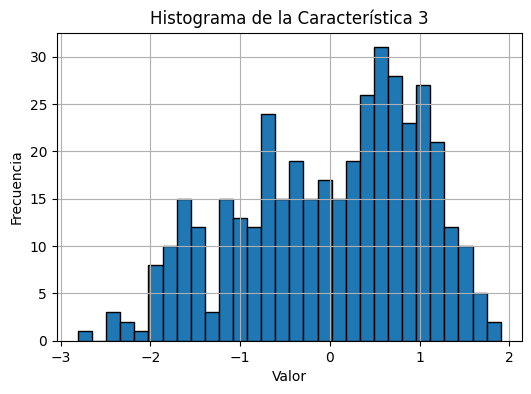

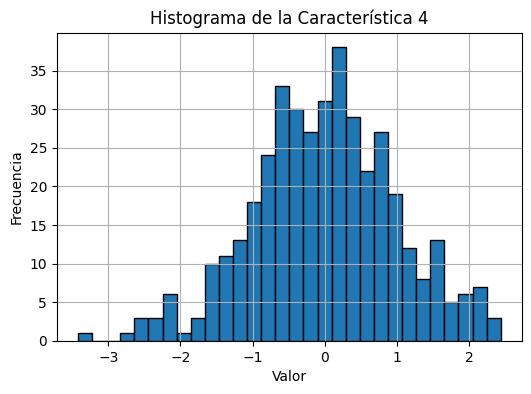

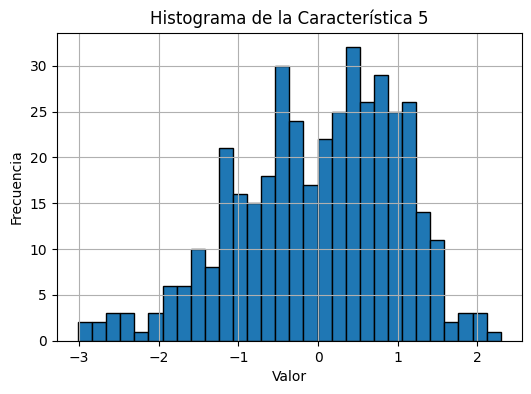

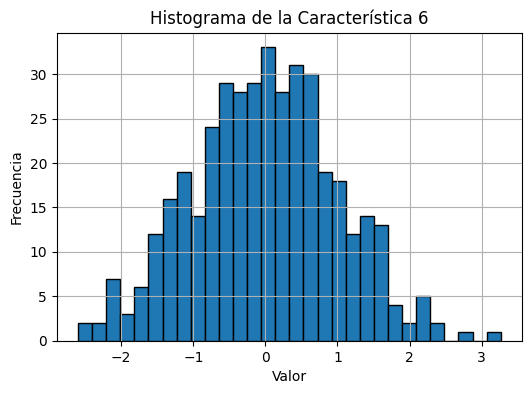

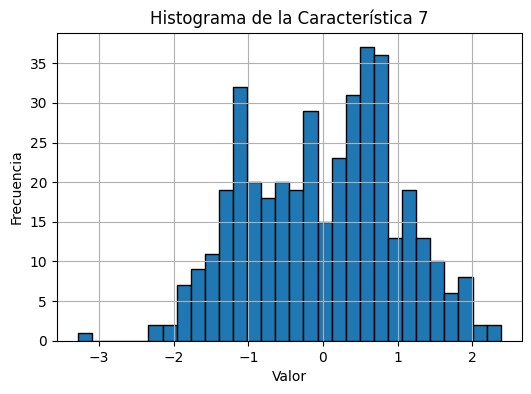

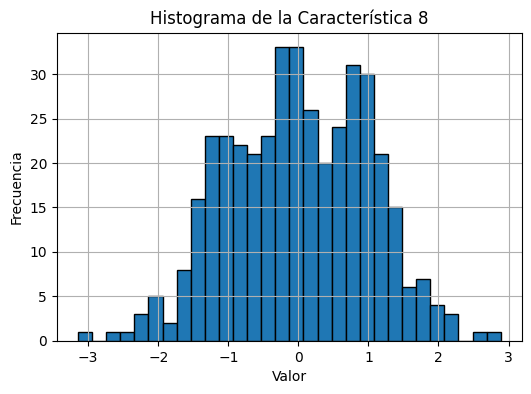

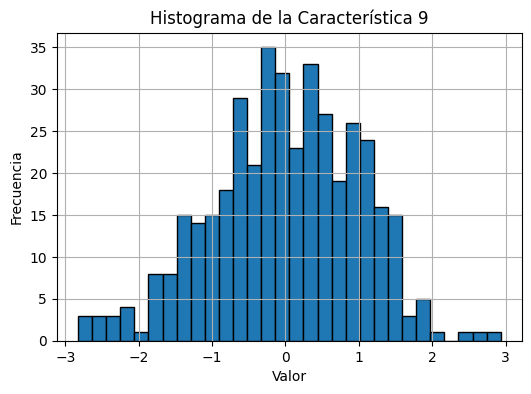

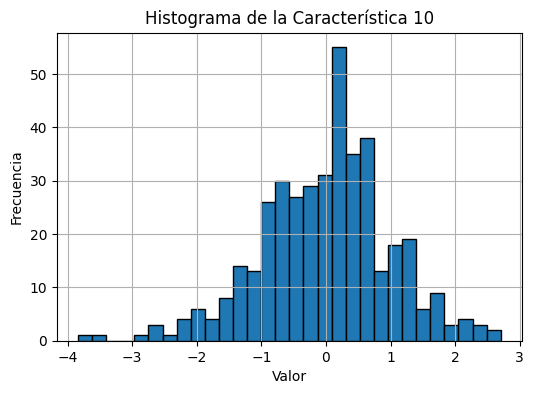

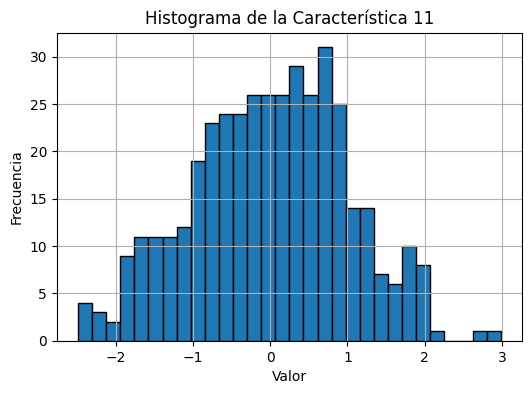

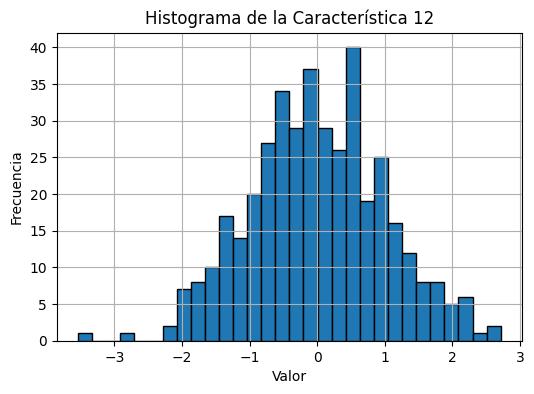

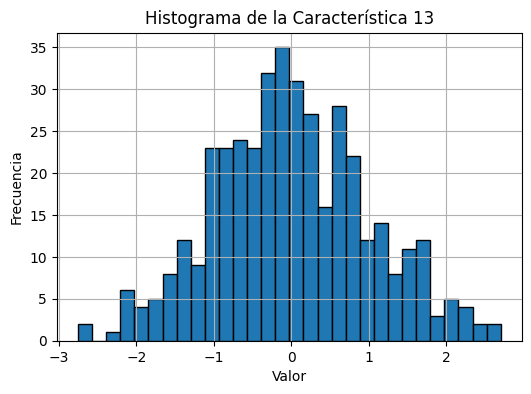

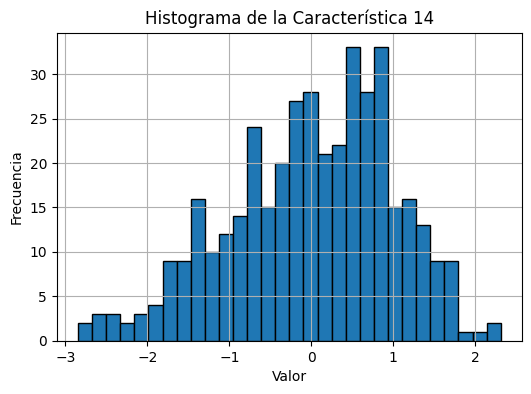

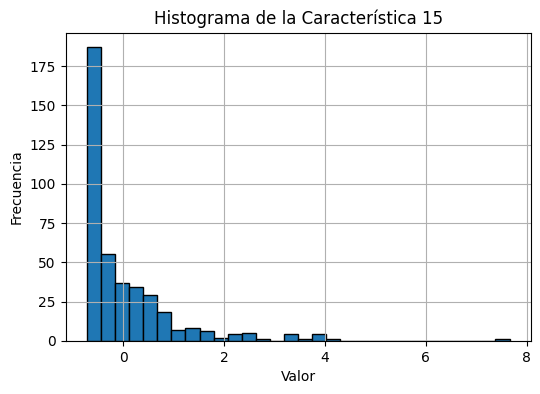

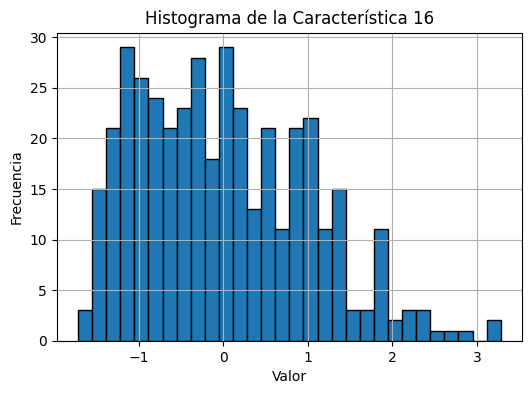

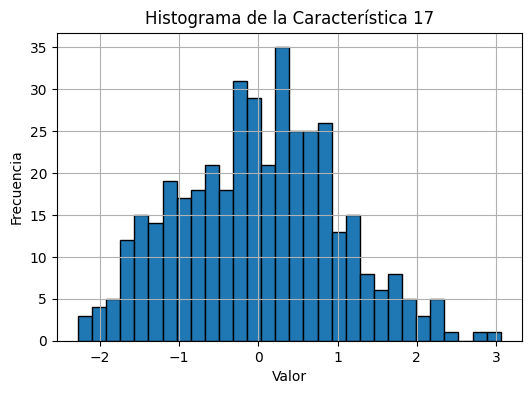

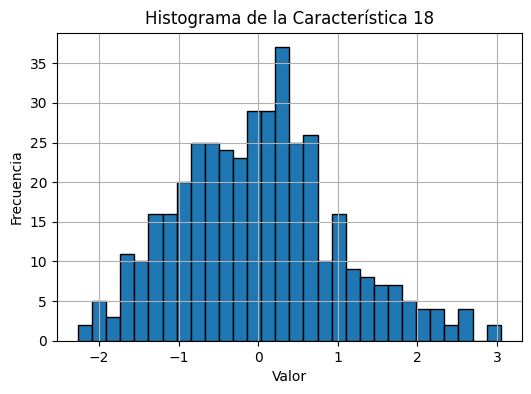

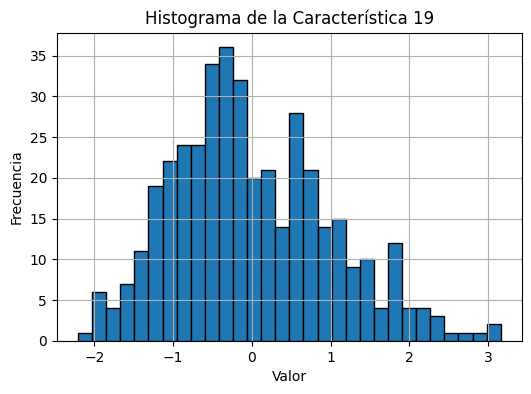

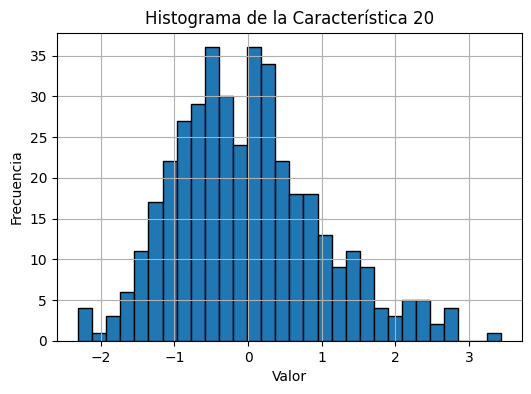

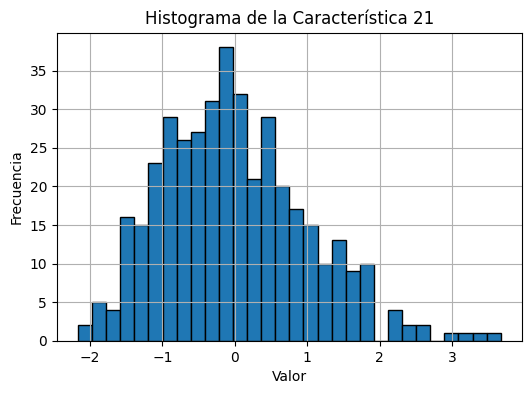

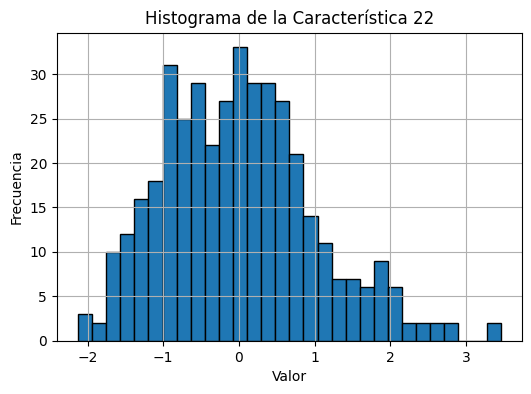

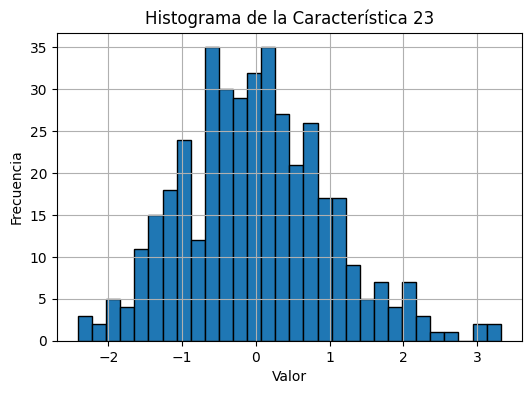

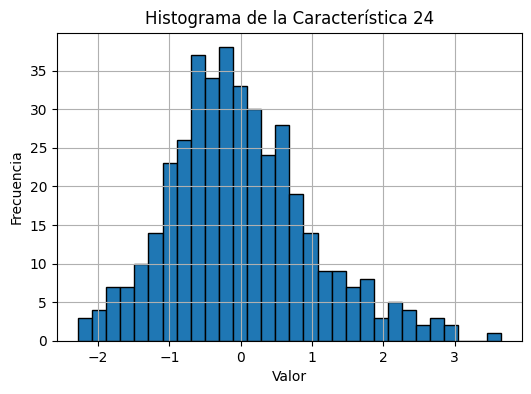

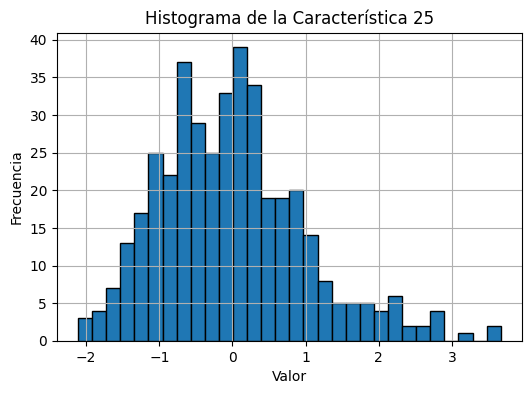

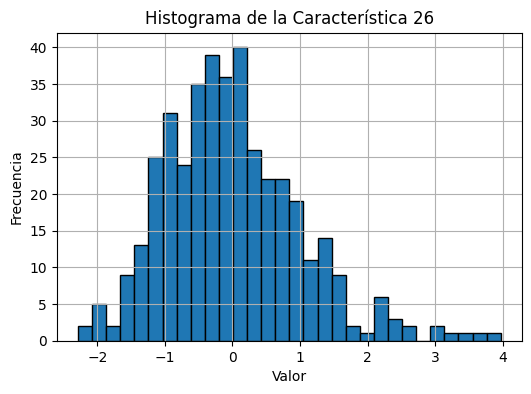

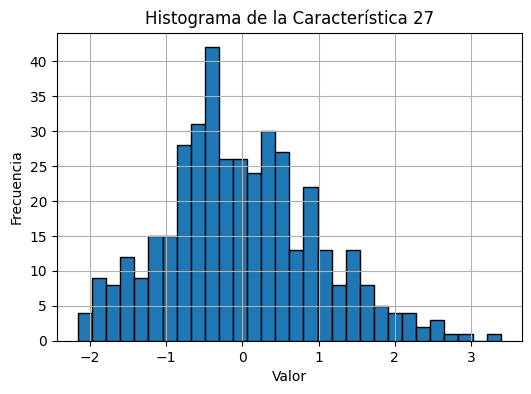

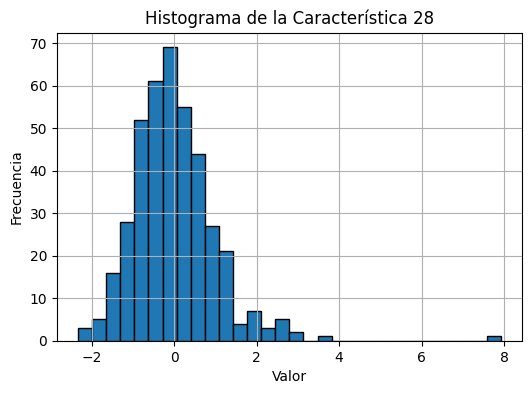

In [ ]:
num_features = len(x_test_scaled_contest[0]) #devuelve 28 de (8,28) --> si pongo len(allFeatures) devuelve 8

for i in range(num_features):
    plt.figure(figsize=(6, 4))  # Tamaño del gráfico
    plt.hist(x_test_scaled_contest[:, i], bins=30, edgecolor='black')  # Crear histograma para la característica i
    # bins --> cantidad de barras (a menos bins mayor ancho barras --> engloban mas los resultados)
    plt.title(f'Histograma de la Característica {i+1}')  # Título del histograma
    plt.xlabel('Valor')  # Etiqueta del eje x
    plt.ylabel('Frecuencia')  # Etiqueta del eje y
    plt.grid(True)  # Habilitar cuadrícula
    plt.show()  # Mostrar el histograma

# RAVDESS


In [ ]:
Ravdess = '/content/drive/MyDrive/TFG/RAVDESS/'

In [ ]:
RavdessAudios = os.listdir(Ravdess)

file_emotion_R = [] #Almacena emocion
file_path_R = []    #Almacena ruta del archivo de audio

for file in RavdessAudios:
    # file_path_R.append(Original + file)  #Para cada file, crea ruta con rutaCarpeta+NombreArchivoAudio
    file_path_posible = Ravdess+file

    part=file.split('-')  #Divide nombre archivo --> ['UO1', 'F', 'A01','E','01.wav'] --> Tercera parte indica emoción
    if part[2] == '01':
      continue
    elif part[2] == '02':
      continue
    elif part[2] == '03':
      if part[3] == '02':
        file_emotion_posible = 'felicidad'
      else:
        continue
    elif part[2]== '04':
      if part[3] == '02':
        file_emotion_posible = 'tristeza'
      else:
        continue
    elif part[2] == '05':
      if part[3] == '02':
        file_emotion_posible = 'ira'
      else:
        continue
    elif part[2] == '06':
      if part[3] == '02':
        file_emotion_posible = 'miedo'
      else:
        continue
    elif part[2] == '07':
      if part[3] == '02':
        file_emotion_posible = 'asco'
      else:
        continue
    elif part[2] == '08':
      if part[3] == '02':
        file_emotion_posible = 'sorpresa'
      else:
        continue
    else:
      file_emotion_posible = 'Unknown'


    file_path_R.append(file_path_posible)
    file_emotion_R.append(file_emotion_posible)

# dataframe para emociones --> 1 coluna llamada Emotions con las emociones
emotion_Ravdess = pd.DataFrame(file_emotion_R, columns=['Emotions'])


# dataframepara path
path_R = pd.DataFrame(file_path_R, columns=['Path'])
Ravdess_df = pd.concat([emotion_Ravdess, path_R], axis=1)
Ravdess_df

Emotions                                               Path
0     tristeza  /content/drive/MyDrive/TFG/RAVDESS/03-01-04-02...
1    felicidad  /content/drive/MyDrive/TFG/RAVDESS/03-01-03-02...
2    felicidad  /content/drive/MyDrive/TFG/RAVDESS/03-01-03-02...
3        miedo  /content/drive/MyDrive/TFG/RAVDESS/03-01-06-02...
4          ira  /content/drive/MyDrive/TFG/RAVDESS/03-01-05-02...
..         ...                                                ...
571  felicidad  /content/drive/MyDrive/TFG/RAVDESS/03-01-03-02...
572   tristeza  /content/drive/MyDrive/TFG/RAVDESS/03-01-04-02...
573   tristeza  /content/drive/MyDrive/TFG/RAVDESS/03-01-04-02...
574        ira  /content/drive/MyDrive/TFG/RAVDESS/03-01-05-02...
575   tristeza  /content/drive/MyDrive/TFG/RAVDESS/03-01-04-02...

[576 rows x 2 columns]

from matplotlib import pyplot as plt
import seaborn as sns
Ravdess_df.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

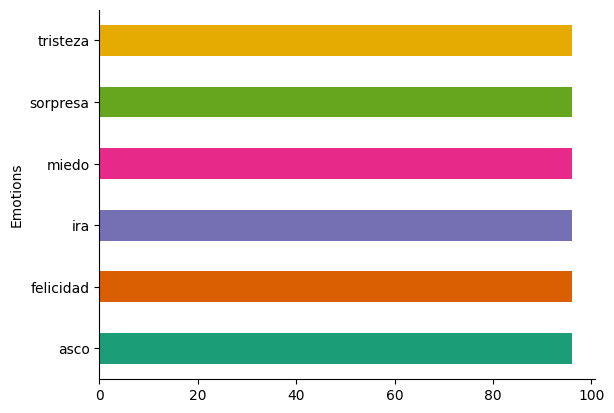

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
Ravdess_df.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
allFeaturesRavdess = FeatureExtraction(Ravdess_df)

In [ ]:
scaler_ravdess = StandardScaler()
scaler_ravdess.fit(allFeaturesRavdess)
allFeaturesRavdess_scaled = scaler_ravdess.transform(allFeaturesRavdess) #Escalamos

# allFeaturesRavdess_scaled = scaler_train.transform(allFeaturesRavdess) #Escalamos

In [ ]:
ravel_emotion_Rv = np.ravel(emotion_Ravdess)
prediccionesRv_prob = modelo.predict_proba(allFeaturesRavdess_scaled)
predicciones_Rv = []

for i in range(len(prediccionesRv_prob)):
  probabilidadesRv_predichas = prediccionesRv_prob[i]
  emocionRv_prediccion = np.argmax(probabilidadesRv_predichas)
  predicciones_Rv.append(mapeo_emociones[emocionRv_prediccion])

  # if y_test_flat[i] != prediccion_emocion[i]:
  #   print("hola")

predicciones_Rv = np.array(predicciones_Rv)

In [ ]:
# predicciones_rv = modelo.predict(allFeaturesRavdess_scaled) #Predicciones (todos datos son de test)

In [ ]:
accuracy_Rav = accuracy_score(
            y_true    = ravel_emotion_Rv,
            y_pred    = predicciones_Rv,
            normalize = True # =False --> devuelve el numero de las acertadas
           )
print("")
print(f"El accuracy de test es: {100*accuracy_Rav}%")


El accuracy de test es: 29.34027777777778%


In [ ]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix_Rv = pd.crosstab(
    np.ravel(ravel_emotion_Rv),
    predicciones_Rv,
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix_Rv

Predicción  asco  felicidad  ira  miedo  sorpresa  tristeza
Real                                                       
asco          65          1    5      5        11         9
felicidad     40         20    5     22         9         0
ira            6         32   29      3        26         0
miedo         15         38    9     16        16         2
sorpresa      58          2    4     17         9         6
tristeza      35          8    1     20         2        30

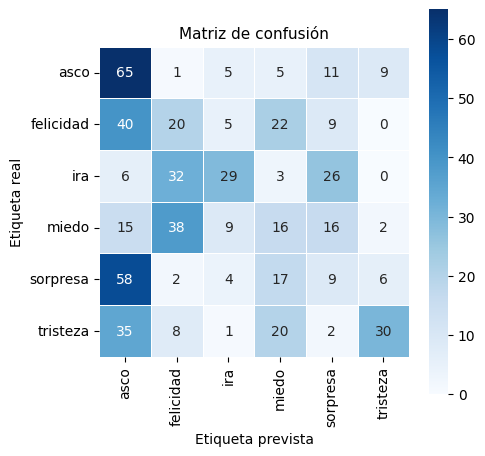

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_Rv, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
plt.title('Matriz de confusión', size=11)
plt.ylabel('Etiqueta real');
plt.xlabel('Etiqueta prevista');
all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy_Rav)
plt.show()

In [ ]:
# Calcular la matriz de confusión
mc_rv = confusion_matrix(np.ravel(ravel_emotion_Rv), predicciones_Rv)

# Calcular el porcentaje de acierto para cada etiqueta
accuracy_per_class = mc_rv.diagonal() / mc_rv.sum(axis=1)

# Imprimir el porcentaje de acierto para cada etiqueta
for i, acc in enumerate(accuracy_per_class):
    print(f'Precisión para la clase {mapeo_emociones[i]}: {acc:.2%}')

Precisión para la clase asco: 67.71%
Precisión para la clase felicidad: 20.83%
Precisión para la clase ira: 30.21%
Precisión para la clase miedo: 16.67%
Precisión para la clase sorpresa: 9.38%
Precisión para la clase tristeza: 31.25%


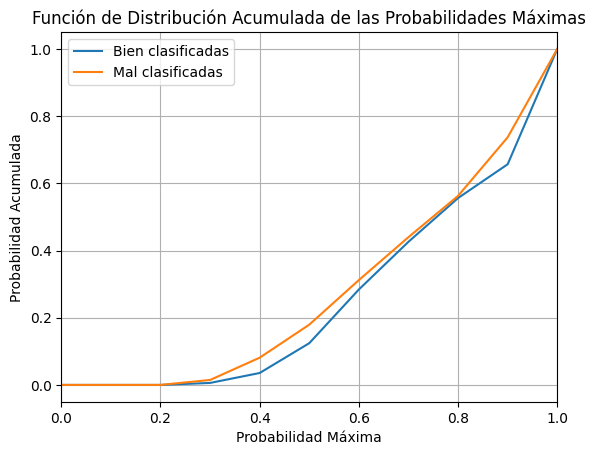

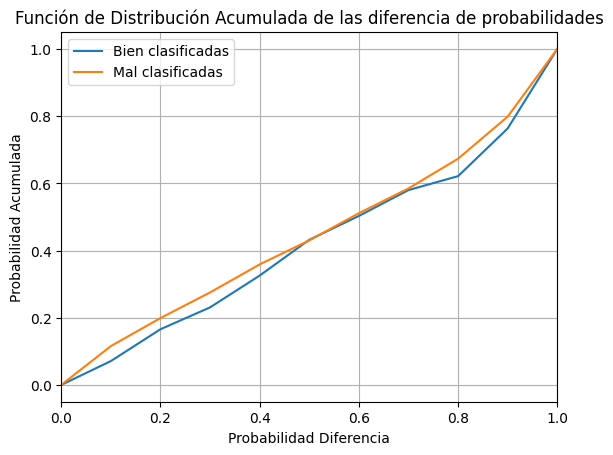

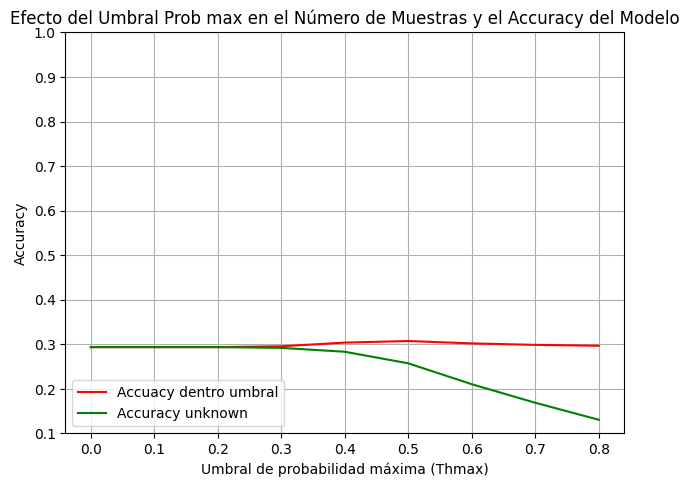

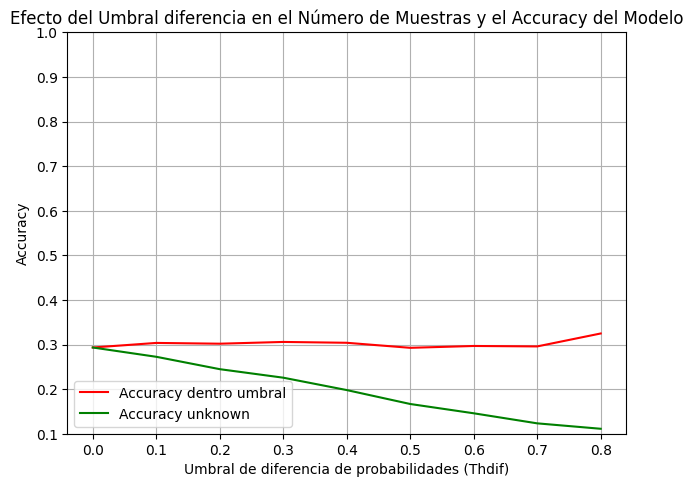

In [ ]:
cdf_Probmax(prediccionesRv_prob, predicciones_Rv, ravel_emotion_Rv)
cdf_Probdif(prediccionesRv_prob, predicciones_Rv, ravel_emotion_Rv)

Thmax_range = np.arange(0.0, 0.9, 0.1)
Thdif_range = np.arange(0.0, 0.9, 0.1)

calcular_accuracy_umbral_Prob(prediccionesRv_prob, predicciones_Rv, allFeaturesRavdess_scaled, ravel_emotion_Rv, Thmax_range)
calcular_accuracy_umbral_Dif(prediccionesRv_prob, predicciones_Rv, allFeaturesRavdess_scaled, ravel_emotion_Rv, Thdif_range)

In [ ]:
ThMax_Rv = 0.3
ThDif_Rv = 0.1
prediccionesRv_ConUn, X_testRv_ConUn, Y_testRv_ConUn, perdidasRv_ConUn, perdidasRv_malas_ConUn = ClaseUnknown(prediccionesRv_prob,predicciones_Rv, allFeaturesRavdess_scaled, ravel_emotion_Rv, ThMax_Rv, ThDif_Rv)

prediccionesRv_Ignorando, X_testRv_Ignorando, Y_testRv_Ignorando, perdidasRv_Ignorando, perdidasRv_malas_Ignorando, biendentroRv = DescartaFueraUmbral(prediccionesRv_prob,predicciones_Rv, allFeaturesRavdess_scaled, ravel_emotion_Rv, ThMax_Rv, ThDif_Rv)

accuracyRv_ConUn = accuracy_score(Y_testRv_ConUn,prediccionesRv_ConUn)
print("")
print(f"El accuracy (creando Unknown) para ThprobMax={ThMax_Rv} y Thdif={ThDif_Rv} es: {100*accuracyRv_ConUn}%, \npero se tienen {perdidasRv_ConUn} perdidas de datos bien clasificados y {perdidasRv_malas_ConUn} perdidas de datos mal clasificados")

print("")
accuracyRv_Ignorando = accuracy_score(Y_testRv_Ignorando,prediccionesRv_Ignorando)
print(f"El accuracy (ignorando muestras fuera umbral) para ThprobMax={ThMax_Rv} y Thdif={ThDif_Rv} es: {100*accuracyRv_Ignorando}%, \npero se tienen {perdidasRv_Ignorando} perdidas de datos bien clasificados y {perdidasRv_malas_Ignorando} perdidas de datos mal clasificados")



El accuracy (creando Unknown) para ThprobMax=0.3 y Thdif=0.1 es: 27.256944444444443%, 
pero se tienen 12 perdidas de datos bien clasificados y 47 perdidas de datos mal clasificados

El accuracy (ignorando muestras fuera umbral) para ThprobMax=0.3 y Thdif=0.1 es: 30.36750483558994%, 
pero se tienen 12 perdidas de datos bien clasificados y 47 perdidas de datos mal clasificados


In [ ]:
# num_features = len(allFeaturesRavdess[0])

# plt.figure(figsize=(10, 6))  # Tamaño de la figura

# # Crear un boxplot para cada característica
# plt.boxplot(allFeaturesRavdess, vert=False, patch_artist=True)

# # Configurar etiquetas y título
# plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
# plt.title('Rango de Valores de Características: Todos Audios (Bd buena)')
# # Mostrar la figura
# plt.show()

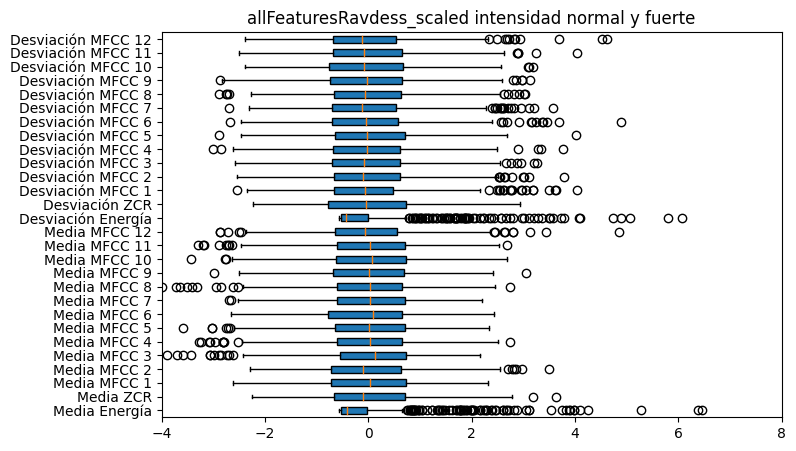

In [ ]:
num_features = len(allFeaturesRavdess_scaled[0])

plt.figure(figsize=(8, 5))  # Tamaño de la figura

# Crear un boxplot para cada característica
plt.boxplot(allFeaturesRavdess_scaled, vert=False, patch_artist=True)

# Configurar etiquetas y título
# plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
plt.yticks(range(1, num_features + 1), feature_names)
plt.title('allFeaturesRavdess_scaled intensidad normal y fuerte')
plt.xlim([-4,8])
# Mostrar la figura
plt.show()

In [ ]:
# num_features = len(x_test_scaled[0])

# plt.figure(figsize=(10, 6))  # Tamaño de la figura

# # Crear un boxplot para cada característica
# plt.boxplot(x_test_scaled, vert=False, patch_artist=True)

# # Configurar etiquetas y título
# plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
# plt.title('Rango de Valores de Características')
# # Mostrar la figura
# plt.show()

In [ ]:
# num_features = len(allFeatures[0])

# plt.figure(figsize=(10, 6))  # Tamaño de la figura

# # Crear un boxplot para cada característica
# plt.boxplot(allFeatures, vert=False, patch_artist=True)

# # Configurar etiquetas y título
# plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
# plt.title('Rango de Valores de Características: Todos Audios (Bd buena)')
# # Mostrar la figura
# plt.show()

# EmoMatchSpanish

In [ ]:
EmoMatchSpanish = '/content/drive/MyDrive/TFG/EmoMatchSpanish/'

In [ ]:
EmoMatchSpanishAudios = os.listdir(EmoMatchSpanish)

file_emotion_Es = [] #Almacena emocion
file_path_Es= []    #Almacena ruta del archivo de audio

for files in EmoMatchSpanishAudios:
    file_path_posible_Es = EmoMatchSpanish+files


    part=files.split('_')
    if part[1] == 'Asco':
      file_emotion_posible_Es = 'asco'
    elif part[1] == 'Ira':
      file_emotion_posible_Es = 'ira'
    elif part[1] == 'Miedo':
      file_emotion_posible_Es = 'miedo'
    elif part[1] == 'Alegria':
      file_emotion_posible_Es = 'felicidad'
    elif part[1] == 'Tristeza':
      file_emotion_posible_Es = 'tristeza'
    elif part[1] == 'Sorpresa':
      file_emotion_posible_Es = 'sorpresa'
    elif part[1] == 'Neutro':
      continue
    else:
      file_emotion_posible_Es = 'Unknown'

    file_path_Es.append(file_path_posible_Es)
    file_emotion_Es.append(file_emotion_posible_Es)


emotion_Es = pd.DataFrame(file_emotion_Es, columns=['Emotions'])


# dataframepara path
path_Es = pd.DataFrame(file_path_Es, columns=['Path'])
EmoMatchSpanish_df = pd.concat([emotion_Es, path_Es], axis=1)
EmoMatchSpanish_df

Emotions                                               Path
0      sorpresa  /content/drive/MyDrive/TFG/EmoMatchSpanish/32_...
1         miedo  /content/drive/MyDrive/TFG/EmoMatchSpanish/41_...
2      tristeza  /content/drive/MyDrive/TFG/EmoMatchSpanish/45_...
3      sorpresa  /content/drive/MyDrive/TFG/EmoMatchSpanish/12_...
4      sorpresa  /content/drive/MyDrive/TFG/EmoMatchSpanish/31_...
...         ...                                                ...
1530   sorpresa  /content/drive/MyDrive/TFG/EmoMatchSpanish/02_...
1531        ira  /content/drive/MyDrive/TFG/EmoMatchSpanish/07_...
1532  felicidad  /content/drive/MyDrive/TFG/EmoMatchSpanish/06_...
1533   sorpresa  /content/drive/MyDrive/TFG/EmoMatchSpanish/04_...
1534      miedo  /content/drive/MyDrive/TFG/EmoMatchSpanish/02_...

[1535 rows x 2 columns]

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Emotions')):
  _plot_series(series, series_name, i)
  fig.legend(title='Emotions', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_4['Emotions'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_4, x='index', y='Emotions', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-13-5dd24a183649>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(_df_4, x='index', y='Emotions', inner='box', palette='Dark2')


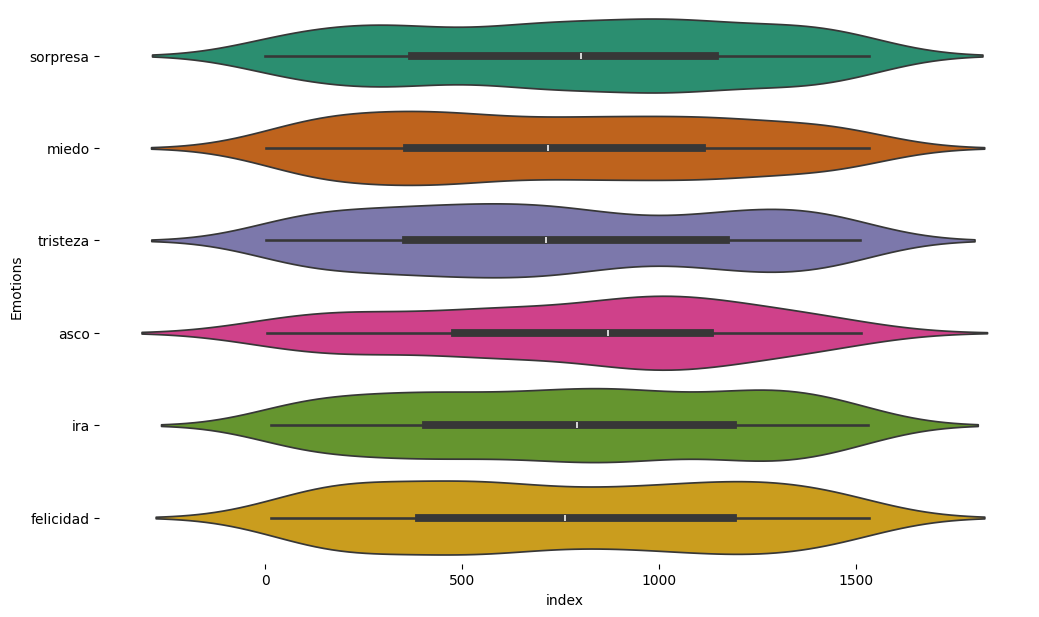

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_4['Emotions'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_4, x='index', y='Emotions', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

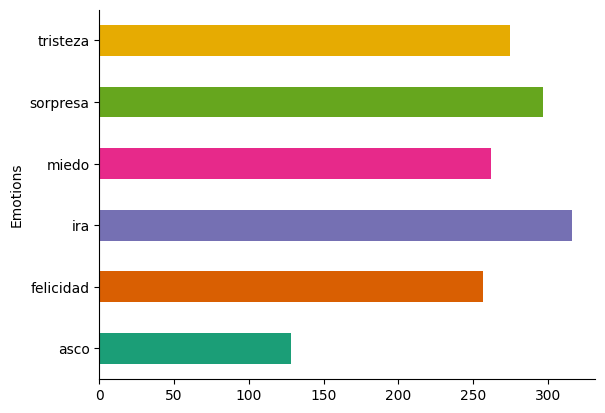

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
EmoMatchSpanish_df.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
allFeaturesEmoMatch = FeatureExtraction(EmoMatchSpanish_df)

In [ ]:
scaler_Es = StandardScaler()
scaler_Es.fit(allFeaturesEmoMatch)
allFeaturesEmoMatch_scaled = scaler_Es.transform(allFeaturesEmoMatch) #Escalamos con ella misma

In [ ]:
# emotion_Es_encoded = label_encoder.fit_transform(emotion_Es)

In [ ]:
# predicciones_Es = modelo.predict(allFeaturesEmoMatch_scaled)

In [ ]:
ravel_emotion_Emo = np.ravel(emotion_Es)
prediccionesEmo_prob = modelo.predict_proba(allFeaturesEmoMatch_scaled)
predicciones_Emo = []

for i in range(len(prediccionesEmo_prob)):
  probabilidadesEmo_predichas = prediccionesEmo_prob[i]
  emocionEmo_prediccion = np.argmax(probabilidadesEmo_predichas)
  predicciones_Emo.append(mapeo_emociones[emocionEmo_prediccion])

  # if y_test_flat[i] != prediccion_emocion[i]:
  #   print("hola")

predicciones_Emo = np.array(predicciones_Emo)

In [ ]:
accuracy_Emo = accuracy_score(
            y_true    = emotion_Es,
            y_pred    = predicciones_Emo,
            normalize = True # =False --> devuelve el numero de las acertadas
           )
print("")
print(f"El accuracy de test es: {100*accuracy_Emo}%")


El accuracy de test es: 23.452768729641694%


In [ ]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix_Es = pd.crosstab(
    ravel_emotion_Emo,
    predicciones_Emo,
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix_Es

Predicción  asco  felicidad  ira  miedo  sorpresa  tristeza
Real                                                       
asco          50          2   20     30        19         7
felicidad     62         25   25     52        86         7
ira           49         57   79     27       103         1
miedo         99         15   34     64        29        21
sorpresa      70         26   36     86        70         9
tristeza      84          6    3     96        14        72

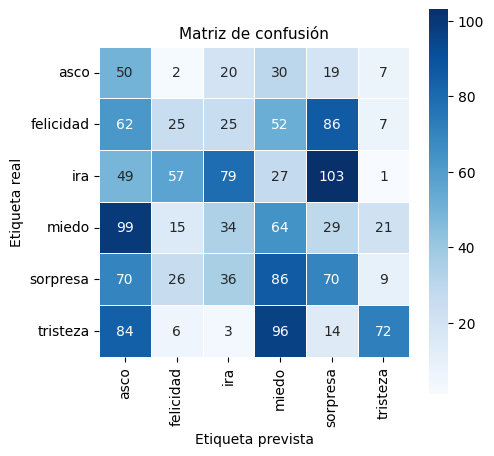

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_Es, annot=True, fmt="", linewidths=.5, square = True, linecolor='white', cmap='Blues');
plt.title('Matriz de confusión', size=11)
plt.ylabel('Etiqueta real');
plt.xlabel('Etiqueta prevista');
all_sample_title = 'Puntuación de precisión: {0}'.format(accuracy_Emo)
plt.show()

In [ ]:
# Calcular la matriz de confusión
mc_Emo = confusion_matrix(emotion_Es, predicciones_Emo)

# Calcular el porcentaje de acierto para cada etiqueta
accuracy_per_class_emo = mc_Emo.diagonal() / mc_Emo.sum(axis=1)

# Imprimir el porcentaje de acierto para cada etiqueta
for i, acc in enumerate(accuracy_per_class_emo):
    print(f'Precisión para la clase {mapeo_emociones[i]}: {acc:.2%}')

Precisión para la clase asco: 39.06%
Precisión para la clase felicidad: 9.73%
Precisión para la clase ira: 25.00%
Precisión para la clase miedo: 24.43%
Precisión para la clase sorpresa: 23.57%
Precisión para la clase tristeza: 26.18%


In [ ]:
# Informe de clasificación
informe_clasificacion_emo = classification_report(emotion_Es, predicciones_Emo)
print("Informe de Clasificación:")
print(informe_clasificacion_emo)

Informe de Clasificación:
              precision    recall  f1-score   support

        asco       0.12      0.39      0.18       128
   felicidad       0.19      0.10      0.13       257
         ira       0.40      0.25      0.31       316
       miedo       0.18      0.24      0.21       262
    sorpresa       0.22      0.24      0.23       297
    tristeza       0.62      0.26      0.37       275

    accuracy                           0.23      1535
   macro avg       0.29      0.25      0.24      1535
weighted avg       0.31      0.23      0.25      1535



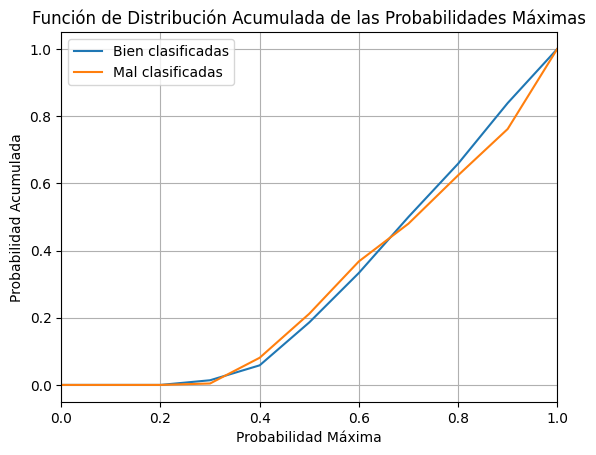

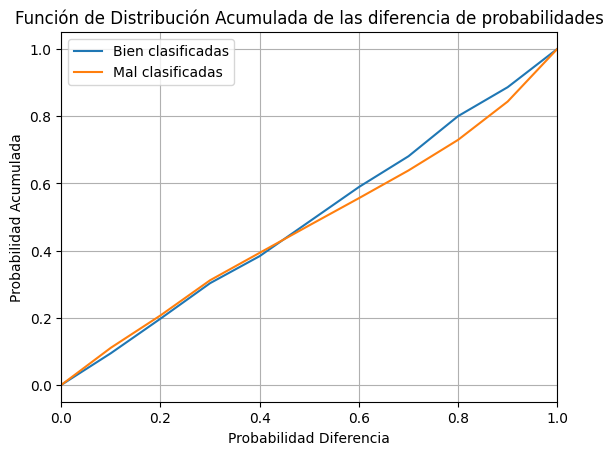

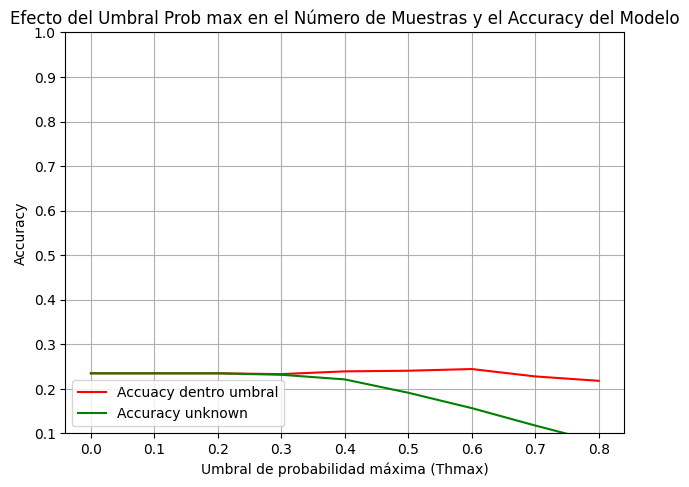

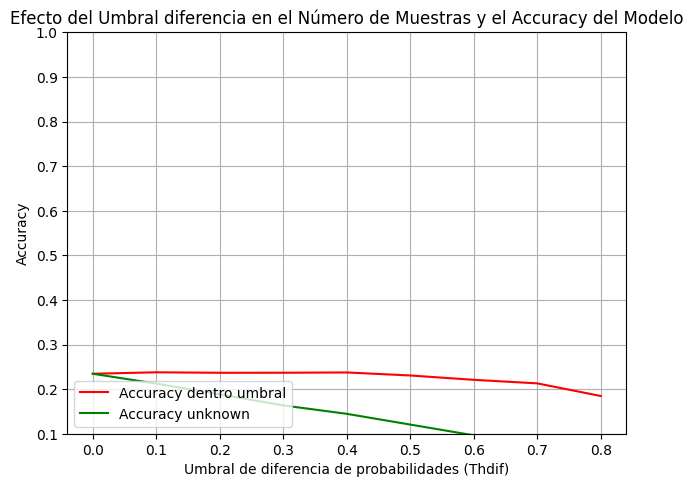

In [ ]:
cdf_Probmax(prediccionesEmo_prob, predicciones_Emo, ravel_emotion_Emo)
cdf_Probdif(prediccionesEmo_prob, predicciones_Emo, ravel_emotion_Emo)

Thmax_range = np.arange(0.0, 0.9, 0.1)
Thdif_range = np.arange(0.0, 0.9, 0.1)

calcular_accuracy_umbral_Prob(prediccionesEmo_prob, predicciones_Emo, allFeaturesEmoMatch_scaled, ravel_emotion_Emo, Thmax_range)
calcular_accuracy_umbral_Dif(prediccionesEmo_prob, predicciones_Emo, allFeaturesEmoMatch_scaled, ravel_emotion_Emo, Thdif_range)

In [ ]:
ThMax_Emo = 0.4
ThDif_Emo = 0.0
prediccionesEmo_ConUn, X_testEmo_ConUn, Y_testEmo_ConUn, perdidasEmo_ConUn, perdidasEmo_malas_ConUn = ClaseUnknown(prediccionesEmo_prob,predicciones_Emo, allFeaturesEmoMatch_scaled, ravel_emotion_Emo, ThMax_Emo, ThDif_Emo)

prediccionesEmo_Ignorando, X_testEmo_Ignorando, Y_testEmo_Ignorando, perdidasEmo_Ignorando, perdidasEmo_malas_Ignorando, biendentroEmo = DescartaFueraUmbral(prediccionesEmo_prob,predicciones_Emo, allFeaturesEmoMatch_scaled, ravel_emotion_Emo, ThMax_Emo, ThDif_Emo)


accuracyEmo_ConUn = accuracy_score(Y_testEmo_ConUn,prediccionesEmo_ConUn)
print("")
print(f"El accuracy (creando Unknown) para ThprobMax={ThMax_Emo} y Thdif={ThDif_Emo} es: {100*accuracyEmo_ConUn}%, \npero se tienen {perdidasEmo_ConUn} perdidas de datos bien clasificados y {perdidasEmo_malas_ConUn} perdidas de datos mal clasificados")

print("")
accuracyEmo_Ignorando = accuracy_score(Y_testEmo_Ignorando,prediccionesEmo_Ignorando)
print(f"El accuracy (ignorando muestras fuera umbral) para ThprobMax={ThMax_Emo} y Thdif={ThDif_Emo} es: {100*accuracyEmo_Ignorando}%, \npero se tienen {perdidasEmo_Ignorando} perdidas de datos bien clasificados y {perdidasEmo_malas_Ignorando} perdidas de datos mal clasificados")



El accuracy (creando Unknown) para ThprobMax=0.4 y Thdif=0.0 es: 22.08469055374593%, 
pero se tienen 21 perdidas de datos bien clasificados y 95 perdidas de datos mal clasificados

El accuracy (ignorando muestras fuera umbral) para ThprobMax=0.4 y Thdif=0.0 es: 23.890063424947147%, 
pero se tienen 21 perdidas de datos bien clasificados y 95 perdidas de datos mal clasificados


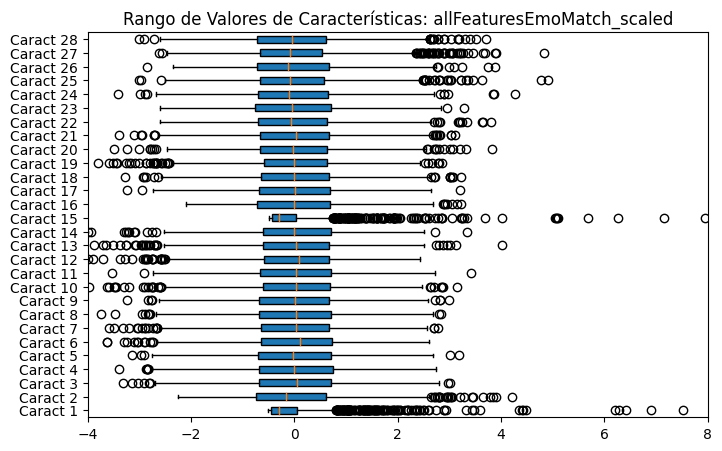

In [ ]:
num_features = len(allFeaturesEmoMatch_scaled[0])

plt.figure(figsize=(8, 5))  # Tamaño de la figura

# Crear un boxplot para cada característica
plt.boxplot(allFeaturesEmoMatch_scaled, vert=False, patch_artist=True)

# Configurar etiquetas y título
plt.yticks(range(1, num_features + 1), [f'Caract {i+1}' for i in range(num_features)])
plt.title('Rango de Valores de Características: allFeaturesEmoMatch_scaled')
plt.xlim([-4,8])
# Mostrar la figura
plt.show()